In [1]:
#Import all necessary modules
%matplotlib inline 
from collections import defaultdict
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')
import scipy.stats as sc
import pickle

from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss,confusion_matrix,classification_report,roc_curve
from sklearn.model_selection import cross_validate, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score, log_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.metrics import plot_roc_curve, hamming_loss

import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load(parse=True,tag=True,entity=True)
import re
import string
import unicodedata as unc
import unidecode as und
import contractions
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from spellchecker import SpellChecker
from gingerit.gingerit import GingerIt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim as gm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from misc_functions import *
import upsetplot as ups

In [2]:
#Read in the training data set
df_train = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Data/train.csv')

In [3]:
#Check first few rows
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


The data consists of six labels of which a comment may have multiple categories. Thus, this is a multi-label classification problem as shown below.

In [4]:
df_train[(df_train['toxic']==1) & (df_train['severe_toxic']==1)].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0
442,01208d2b76624130,Hi \n\nIm a fucking bitch.\n\n50.180.208.181,1,1,1,0,1,0
579,018663f910e0bfe6,What a motherfucking piece of crap those fuckh...,1,1,1,0,1,0


In [5]:
#Check dataset shape
df_train.shape

(159571, 8)

In [6]:
#Check for missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


The training data does not have any missing values. Next, check distribution of labels. Initially, check comment distributions by a single label although as noted above, some are multi-labeled. Each label can be treated as a binary classification problem

In [7]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
          'insult', 'identity_hate']

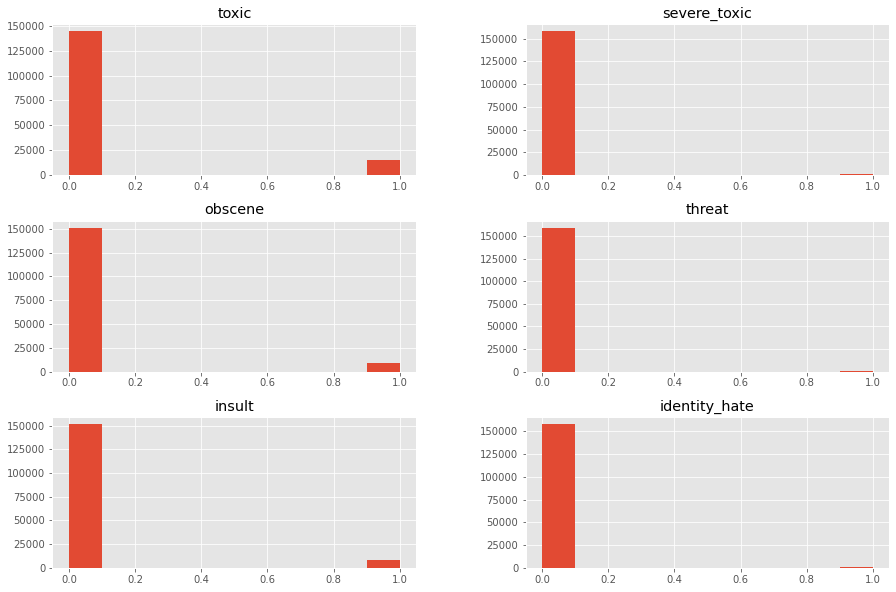

In [8]:
df_train.drop(['id','comment_text'],axis=1).hist(figsize=[15,10]);
#.get_figure().savefig('label_dist.png')

In [9]:
df_train.drop(['id','comment_text'],axis=1).apply(lambda x: pd.Series.value_counts(x, normalize=True)*100)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,90.415552,99.000445,94.705178,99.700447,95.063639,99.119514
1,9.584448,0.999555,5.294822,0.299553,4.936361,0.880486


The dataset is imbalanced as seen above across all labels. Resampling, SMOTE ?

In [10]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
s1 = 'jalape\u00f1o'
s2 = 'jalapeño'
a = unc.normalize('NFKD',s1).encode('ascii','ignore').decode('utf-8','ignore')
b = und.unidecode(s2)

Tasks for text normalization (not in order)
Remove any tags, special characters (like accents, emoji's, etc.)
<br>lower case all the text
<br>remove numbers, special characters, punctuations, stopwords
<br>Expand contractions
<br>Stem / Lemmatize
<br>Tokenize

In [12]:
def clean_text(text):
    
    #Remove url text
    p1 = 'http\S+|https\S+|www\S+'
    text = re.sub(p1,' ',text)
    
    #Replace \n with whitespace
    p2 = '\\n?\\r'
    text = re.sub(p2,' ',text)
    
    #Replace content enclosed within brackets with whitespace
    #p3 = '\([^\)]*\)|\[[^\]]*\]|\{[^\}]*\}'
    p3 = '\(|\)|\[|\]|\{|\}|\<|\>'
    text = re.sub(p3,' ',text)
    
    #Replace any puncuations with whitespace
    punct = list(string.punctuation)
    for a in punct:
        text = text.replace(a,' ')

    #Remove any special characters except alphabetical characters and white space
    p4 = '[^a-zA-Z]|^\s'
    text = re.sub(p4,' ',text)

    #Replace multiple white spaces with single whitespace
    p5 = '\s+'
    text = re.sub(p5,' ',text)
    
    #Remove spaces at start and end of string
    p6 = '^\s|\s$'
    text = re.sub(p6,'',text)
    
    #Convert text to lower-case
    text = text.lower()
    
    return text

In [13]:
def normalizer(column):
    clean = []
    for text in column:
        #Convert accented characters to normal characters
        text = und.unidecode(text)
        
        #Expand contractions
        text = contractions.fix(text)
        
        #Apply clean_text function
        text = clean_text(text)
        #print(text)
        
        #Lemmatize text
        lem = nlp(text)
        lem_text = [token.lemma_ if token.lemma_!='-PRON-' else token.text for token in lem]
        
        #Remove stop words
        stops = [a for a in stopwords.words('english')]
        #stops = [a for a in stopwords.words('english') if a not in ["don't","no","nor","not"]]
        stp = [a for a in lem_text if a not in stops]
        
        #Join text after lemmatizing and removing stop words
        text = ' '.join(stp)
        
        clean.append(text)
    return clean

In [253]:
df_test.loc[469,'comment_text']

'"\nThanks! And happy new year to you too!   \'\'\'\'\'\'  Let\'s talk about it! "'

In [254]:
df_test.loc[469,'clean_text']

'thanks happy new year let us talk'

In [14]:
# df_test = df_train.copy()
# df_test['clean_text'] = normalizer(df_test['comment_text'])
# df_test['tokens'] = df_test['clean_text'].apply(word_tokenize)

In [15]:
#df_test.to_pickle('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Data/Cleaned Data/train.pkl')

In [16]:
unpc = pd.read_pickle('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Data/Cleaned Data/train.pkl')
df_test = unpc.copy()

In [17]:
#Font Sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [436]:
len(df_train) - df_stat['Count'].sum()

124473

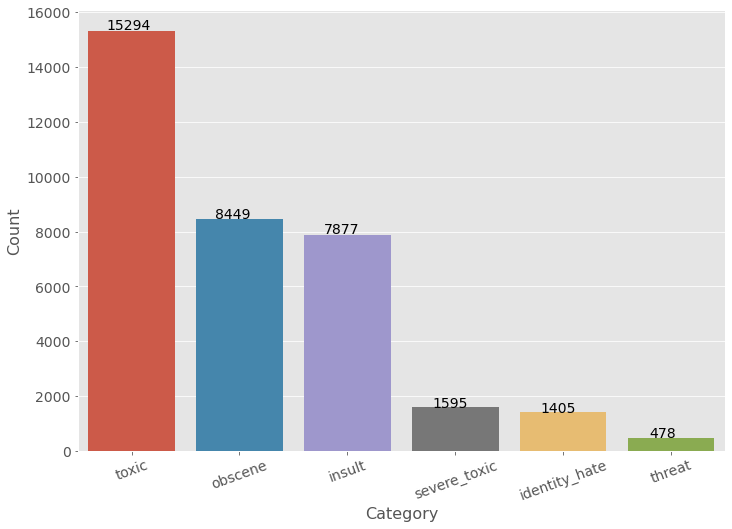

In [460]:
count = []
for a in labels:
    count.append((a,df_train[a].sum()))
    df_stat = pd.DataFrame(count,columns=['Category','Count'])
    #df_stat.loc[len(df_stat.index)] = ['Safe', sum(df_stat['Count'])]

plt.figure(figsize=[10,7])
plt.xticks(rotation=20)
plt.tight_layout()
df_stat = df_stat.sort_values('Count',ascending=False)
bplot = sns.barplot(x='Category',y='Count',data=df_stat)
for p in bplot.patches:
    bplot.annotate(str(round(p.get_height())), (p.get_x() * 1.005 + 0.17, p.get_height() * 1.005))
bplot.get_figure().savefig('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Figures/label_dist.png',bbox_inches='tight')

In [459]:
df_test['Category_Count']

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Name: Category_Count, Length: 159571, dtype: int64

Checking number of comments for each category. Majority of the comments do not belong to any of the six categories. Next, check comments with multiple labels

In [439]:
df_test['Category_Count'] = df_test.iloc[:,2:8].sum(axis=1)
df_test['none'] = (df_test[labels].max(axis=1) == 0).astype(int)

% Data without any labels:  89.83 %


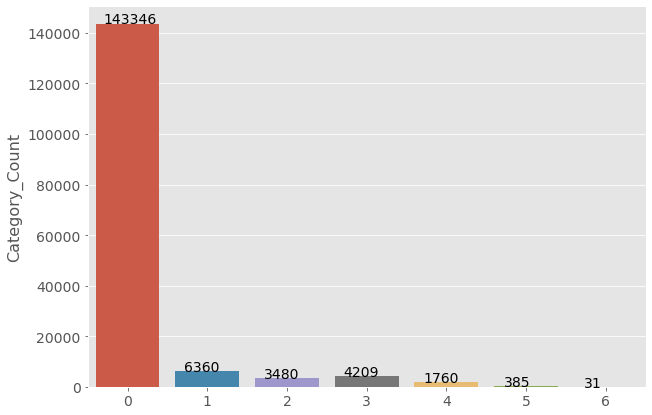

In [440]:
df_test.head()
Cat_count = df_test['Category_Count'].value_counts()
plt.figure(figsize=[10,7])
mplot = sns.barplot(x=Cat_count.index,y=Cat_count)
for p in mplot.patches:
    mplot.annotate(str(round(p.get_height())), (p.get_x() * 1.005 + 0.1, p.get_height() * 1.005))
mplot.get_figure().savefig('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Figures/cat_bar.png',bbox_inches='tight')
print('% Data without any labels: ',round((Cat_count[0]/Cat_count.sum()*100),2),'%')

Majority of the comments do not belong to any of the other five categories. Plot the bar plot without the '0' category

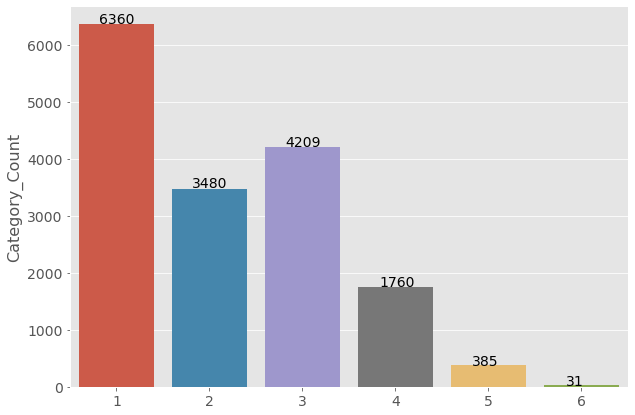

In [102]:
plt.figure(figsize=[10,7])
mplot_6 = sns.barplot(x=Cat_count[1:].index,y=Cat_count[1:])
for p in mplot_6.patches:
    mplot_6.annotate(str(round(p.get_height())), (p.get_x() * 1.005 + 0.21, p.get_height() * 1.005))
mplot_6.get_figure().savefig('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/Figures/cat_bar_6.png',bbox_inches='tight')

In [25]:
#Check top combinations for overlapping labels
df_combination = df_test.groupby(labels).size().sort_values(ascending=False).reset_index().rename(columns={0:'Count'})
df_combination.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,Count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215
5,1,1,1,0,1,0,989
6,1,0,1,0,1,1,618
7,0,0,1,0,0,0,317
8,0,0,0,0,1,0,301
9,1,1,1,0,1,1,265


Safe comments account for the majority of comments, followed by some combinations with the label 'toxic' in the top 10 combinations

In [26]:
for a in [b for b in labels if b !='toxic']:
    count_sep = df_combination[(df_combination[a]==1)&(df_combination['toxic']==0)]['Count'].sum()
    count_both = df_combination[(df_combination[a]==1) & (df_combination['toxic']==1)]['Count'].sum()
    print('% ',a,'comments also labeled toxic: ',round((100-(count_sep/count_both)*100),2))

%  severe_toxic comments also labeled toxic:  100.0
%  obscene comments also labeled toxic:  93.4
%  threat comments also labeled toxic:  93.54
%  insult comments also labeled toxic:  92.74
%  identity_hate comments also labeled toxic:  92.09


Most comments that have other labels are also tagged as 'toxic'. All severly toxic comments are all tagged toxic.

In [27]:
#Reference: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
def get_top_n_words(corpus, n=None,stopwords=None):
    vec = CountVectorizer(stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

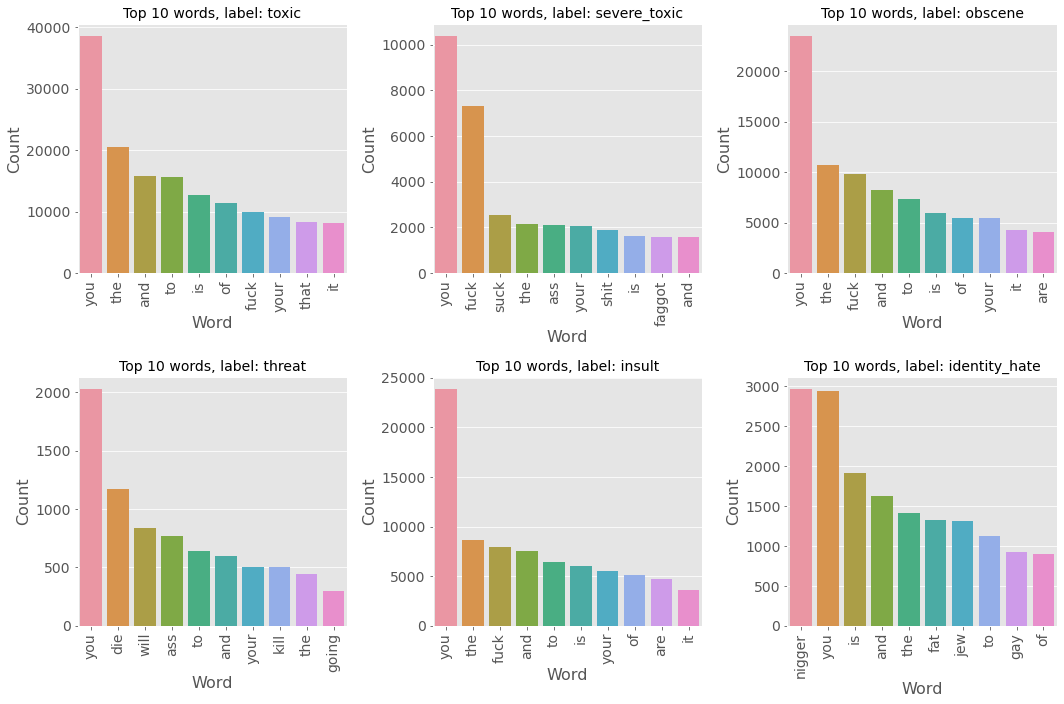

In [28]:
plt.figure(figsize=[15,10])
c=1
for a in labels:
    data = df_test[df_test[a]==1]['comment_text']
    freq_words = get_top_n_words(data,n=10)
    df_freq = pd.DataFrame(freq_words,columns=['Word','Count']).set_index('Word')
    plt.subplot(2,3,c)
    sns.barplot(x=df_freq.index,y=df_freq.Count)
    plt.title('Top 10 words, label: {}'.format(a))
    plt.xticks(rotation=90)
    c+=1
    plt.tight_layout()

The above plots are without removing stop words. Next, try with removal of stop words.

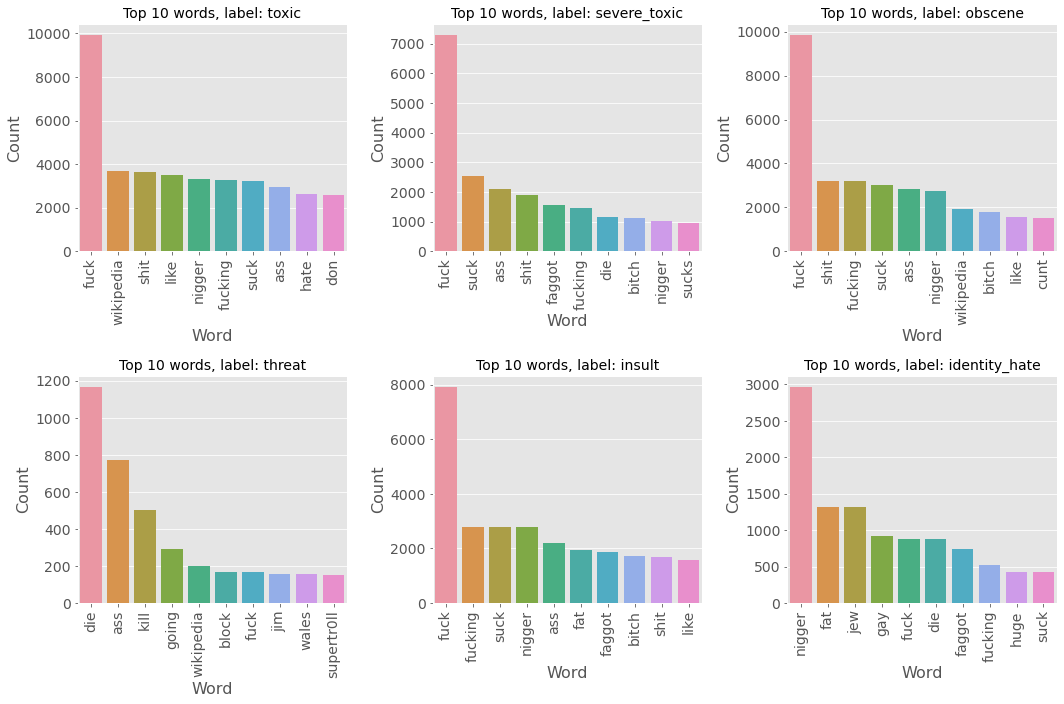

In [29]:
plt.figure(figsize=[15,10])
c=1
for a in labels:
    data = df_test[df_test[a]==1]['comment_text']
    freq_words = get_top_n_words(data,n=10,stopwords='english')
    df_freq = pd.DataFrame(freq_words,columns=['Word','Count']).set_index('Word')
    plt.subplot(2,3,c)
    sns.barplot(x=df_freq.index,y=df_freq.Count)
    plt.title('Top 10 words, label: {}'.format(a))
    plt.xticks(rotation=90)
    c+=1
    plt.tight_layout()

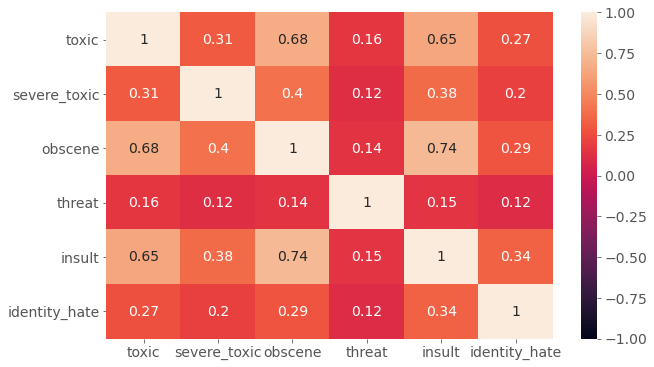

In [30]:
df_lb = df_test[labels]
plt.figure(figsize=[10,6])
sns.heatmap(df_lb.corr(),vmin=-1,vmax=1,annot=True);

In [31]:
def word_cloud(column,label):
    corpus = ' '
    for text in column:
        for token in text:
            corpus = corpus + token + ' '
    cloud = WordCloud(background_color='black',max_words=200,
                      max_font_size=70,collocations=False).generate(corpus)
    plt.figure(figsize = (12, 12))
    plt.title(label)
    plt.imshow(cloud) 
    plt.axis("off") 
    plt.tight_layout() 

<br>Next, check word clouds for various labels. (Text can be considered profane, vulgar or offensive)

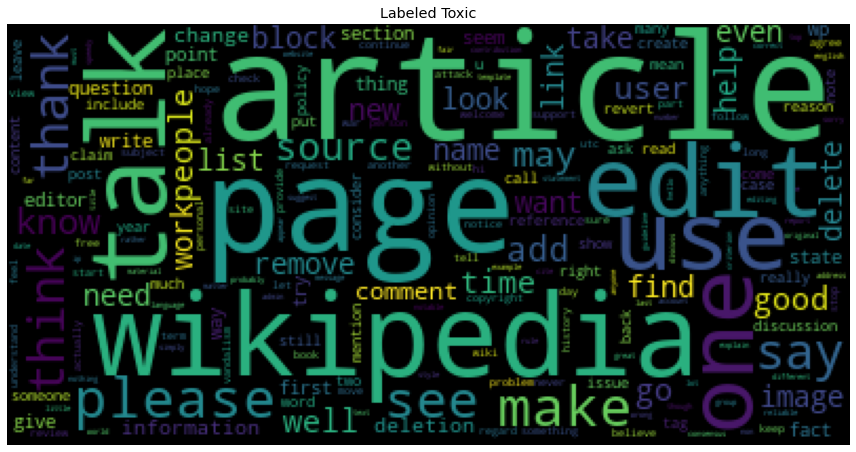

In [175]:
word_cloud(df_test[df_test['none']==1]['tokens'],'Labeled Toxic')

In [255]:
# word_cloud(df_test[df_test['toxic']==1]['tokens'],'Labeled Toxic')
# word_cloud(df_test[df_test['severe_toxic']==1]['tokens'],'Labeled Severe Toxic')
# word_cloud(df_test[df_test['obscene']==1]['tokens'],'Labeled Obscene')
# word_cloud(df_test[df_test['threat']==1]['tokens'],'Labeled Threat')
# word_cloud(df_test[df_test['insult']==1]['tokens'],'Labeled Insult')
# word_cloud(df_test[df_test['identity_hate']==1]['tokens'],'Labeled Identity Hate')

For modeling, the first approach will be to use a Count/tf-idf vectorizer coupled with/without resampling to handle imbalanced data and finally applied with models: Logistic Regression, Multinomial Naive Bayes and Light Gradient Boost

In [259]:
def vectorize(df,count=False,tfidf=False,max_f = 5000):
    if count == True:
        vect = CountVectorizer(max_features=max_f)
    elif tfidf == True:
        vect = TfidfVectorizer(max_features=max_f)
    df_nonempty = df[df['tokens'].str.len()!=0]
    X = df_nonempty[['clean_text','tokens']]
    y = df_nonempty[labels]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    train_vect = vect.fit_transform(X_train['clean_text'])
    test_vect = vect.transform(X_test['clean_text'])
    return train_vect, test_vect, y_train, y_test

In [258]:
def resample_train(X_train,y_train,undersample=False,smote=False,smote_str =0.4,undersample_str=0.5):
    from collections import Counter
    print('Pre-resampling ',Counter(y_train))
    if smote == True:
        sm = SMOTE(random_state=1,sampling_strategy=smote_str)
        #sm = SMOTE(random_state=1)
        X_train,y_train = sm.fit_resample(X_train,y_train)
        print('Oversampling (SMOTE) Class 1 = {}X Class 0 '.format(smote_str),Counter(y_train))
    if undersample == True:
        rus = RandomUnderSampler(sampling_strategy=undersample_str)
        X_train, y_train = rus.fit_resample(X_train,y_train)
        print('Undersampling Class 0 for Class 1 = {}X Class 0'.format(undersample_str),Counter(y_train))
    return X_train, y_train

In [444]:
def clf_mod(df, model,count=False,tfidf=False,resample_all=False,resample_sub=False,max_f=5000,grid=False):
    auc, auc_tr = [], []
    f1, f1_tr = [], []
    #pred, tr_pred = [], []
    #pred_prob, tr_pred_prob = [], []
    Test, Test_pred, Test_prob = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    grid_params = []
    
    for a in labels:
        
        #Vectorize 
        if count == True:
            vect = CountVectorizer(max_features=max_f)
        elif tfidf == True:
            vect = TfidfVectorizer(max_features=max_f)
            
        df_nonempty = df[df['tokens'].str.len()!=0]
        X = df_nonempty['clean_text']
        y = df_nonempty[a]
        
        #Random split into training and test data        
        X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
        X_tr = vect.fit_transform(X_tr)
        X_te = vect.transform(X_te)
        
        y_test_a = pd.DataFrame(y_te.reset_index().drop('index',axis=1))
        Test = pd.concat([Test,y_test_a],axis=1)
        
        #Resampling all or a subset of labels if True
        
        if resample_all == True:
                X_tr, y_tr = resample_train(X_tr,y_tr,smote=True,smote_str=0.6)
        
        elif resample_sub == True:
            if a in ['severe_toxic','threat','identity_hate']:
                X_tr, y_tr = resample_train(X_tr,y_tr,smote=True)
        
        model.fit(X_tr.astype('float'),y_tr)
        if grid == True:
            grid_params.append(model.best_params_)
            print(model.best_estimator_)
            
        y_tr_pred = model.predict(X_tr.astype('float'))
        y_tr_pred_prob = model.predict_proba(X_tr.astype('float'))
        y_te_pred = model.predict(X_te.astype('float'))
        y_te_pred_prob = model.predict_proba(X_te.astype('float'))
        
        #pred.append((a+'_test_pred',y_te_pred))
        
        pred_a = pd.DataFrame(y_te_pred).rename(columns={0:(a+'_test_pred')}).reset_index().drop('index',axis=1)
        Test_pred = pd.concat([Test_pred,pred_a],axis=1)
        
        pred_prob_a = pd.DataFrame(y_te_pred_prob).rename(columns={0:(a+'_0_prob'),1:(a+'_1_prob')}).reset_index().drop('index',axis=1)
        Test_prob = pd.concat([Test_prob,pred_prob_a],axis=1)
        
        #pred_prob.append((a+'_test_pred_prob',y_te_pred_prob))
        #tr_pred.append((a+'_train_pred',y_tr_pred))
        #tr_pred_prob.append((a+'_train_pred_prob',y_tr_pred_prob))
        
        auc_sc = roc_auc_score(y_te,y_te_pred_prob[:,1])
        f1_sc = f1_score(y_te,y_te_pred)
        auc.append(auc_sc)
        f1.append(f1_sc)
        
        auc_sc_tr = roc_auc_score(y_tr,y_tr_pred_prob[:,1])
        f1_sc_tr = f1_score(y_tr,y_tr_pred)
        auc_tr.append(auc_sc_tr)
        f1_tr.append(f1_sc_tr)
        
        print('\nLabel: ',a,', Train Set- AUC: ',round(auc_sc_tr,4),', F1: ',round(f1_sc_tr,4))
        print('Label: ',a,', Test Set- AUC: ',round(auc_sc,4),', F1: ',round(f1_sc,4))
        #model_metrics(y_te,y_te_pred,y_te_pred_prob,title=a)
    
    #predictions_test = pd.DataFrame(dict(pred))
    #predictions_prob_test = pd.DataFrame(dict(pred_prob))
    
    auc_m_tr = round(np.mean(auc_tr),4)
    f1_m_tr = round(np.mean(f1_tr),4)
    auc_m_te = round(np.mean(auc),4)
    f1_m_te = round(np.mean(f1),4)
    hm_l = round(hamming_loss(Test,Test_pred),4)
    ac_sc = round(accuracy_score(Test,Test_pred),4)
    
    print('\nMean Train AUC: ',auc_m_tr,'Mean Train Macro F1: ',f1_m_tr)
    print('Mean Test AUC: ',auc_m_te,'Mean Test Macro F1: ',f1_m_te)
    print('Test Hamming Loss: ', hm_l)
    print('Test Accuracy Score (Exact Match): ', ac_sc)
    
    return {'Train_AUC':auc_tr,'Test_AUC':auc,
            'Train_f1':f1_tr,'Test_f1':f1,
            'Mean_Train_AUC':auc_m_tr,'Mean_Test_AUC':auc_m_te,
            'Mean_Train_F1':f1_m_tr,'Mean_Test_F1':f1_m_te,
            'Test Hamming Loss':hm_l, 'Test Accuracy Score': ac_sc,'Grid Parameters':grid_params}

Three models will be used: Multinomial Naive Bayes, Logistic Regression and Light Gradient Boost
Initially apply count vectorizer and do not resample for all three models. A constant of 7000 max features will be used to compare models.

In [72]:
#df_test[df_test['tokens'].str.len()==0].tail(40)

In [333]:
model = MultinomialNB()
mlt_bow_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9375 , F1:  0.7431
Label:  toxic , Test Set- AUC:  0.9281 , F1:  0.7384

Label:  severe_toxic , Train Set- AUC:  0.9696 , F1:  0.4793
Label:  severe_toxic , Test Set- AUC:  0.9496 , F1:  0.4581

Label:  obscene , Train Set- AUC:  0.9531 , F1:  0.7461
Label:  obscene , Test Set- AUC:  0.9354 , F1:  0.7146

Label:  threat , Train Set- AUC:  0.9664 , F1:  0.2639
Label:  threat , Test Set- AUC:  0.9347 , F1:  0.1983

Label:  insult , Train Set- AUC:  0.9481 , F1:  0.6769
Label:  insult , Test Set- AUC:  0.9362 , F1:  0.6611

Label:  identity_hate , Train Set- AUC:  0.9582 , F1:  0.379
Label:  identity_hate , Test Set- AUC:  0.927 , F1:  0.3435

Mean Train AUC:  0.9555 Mean Train Macro F1:  0.5481
Mean Test AUC:  0.9352 Mean Test Macro F1:  0.519
Test Hamming Loss:  0.0273
Test Accuracy Score (Exact Match):  0.8472


In [334]:
model = LogisticRegression(max_iter=10000)
log_bow_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9811 , F1:  0.8
Label:  toxic , Test Set- AUC:  0.9511 , F1:  0.745

Label:  severe_toxic , Train Set- AUC:  0.9931 , F1:  0.5104
Label:  severe_toxic , Test Set- AUC:  0.9404 , F1:  0.3651

Label:  obscene , Train Set- AUC:  0.992 , F1:  0.8437
Label:  obscene , Test Set- AUC:  0.9616 , F1:  0.7625

Label:  threat , Train Set- AUC:  0.9948 , F1:  0.514
Label:  threat , Test Set- AUC:  0.9553 , F1:  0.2703

Label:  insult , Train Set- AUC:  0.979 , F1:  0.6738
Label:  insult , Test Set- AUC:  0.9351 , F1:  0.587

Label:  identity_hate , Train Set- AUC:  0.9831 , F1:  0.4066
Label:  identity_hate , Test Set- AUC:  0.8935 , F1:  0.1925

Mean Train AUC:  0.9872 Mean Train Macro F1:  0.6248
Mean Test AUC:  0.9395 Mean Test Macro F1:  0.4871
Test Hamming Loss:  0.0204
Test Accuracy Score (Exact Match):  0.8836


In [336]:
model = LGBMClassifier()
lgbm_bow_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9713 , F1:  0.7561
Label:  toxic , Test Set- AUC:  0.9613 , F1:  0.7328

Label:  severe_toxic , Train Set- AUC:  0.9957 , F1:  0.5886
Label:  severe_toxic , Test Set- AUC:  0.9765 , F1:  0.3865

Label:  obscene , Train Set- AUC:  0.992 , F1:  0.8377
Label:  obscene , Test Set- AUC:  0.9849 , F1:  0.806

Label:  threat , Train Set- AUC:  0.9996 , F1:  0.8638
Label:  threat , Test Set- AUC:  0.9307 , F1:  0.2394

Label:  insult , Train Set- AUC:  0.9842 , F1:  0.731
Label:  insult , Test Set- AUC:  0.9702 , F1:  0.6883

Label:  identity_hate , Train Set- AUC:  0.996 , F1:  0.6627
Label:  identity_hate , Test Set- AUC:  0.9639 , F1:  0.3552

Mean Train AUC:  0.9898 Mean Train Macro F1:  0.74
Mean Test AUC:  0.9646 Mean Test Macro F1:  0.5347
Test Hamming Loss:  0.0187
Test Accuracy Score (Exact Match):  0.8927


Next, use tf-idf vectorizer and repeat for the above models with no resampling

In [337]:
model = MultinomialNB()
mlt_tf_res = clf_mod(df_test,model,count=False,tfidf=True,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9633 , F1:  0.6831
Label:  toxic , Test Set- AUC:  0.9599 , F1:  0.6826

Label:  severe_toxic , Train Set- AUC:  0.9775 , F1:  0.2549
Label:  severe_toxic , Test Set- AUC:  0.9711 , F1:  0.178

Label:  obscene , Train Set- AUC:  0.9726 , F1:  0.707
Label:  obscene , Test Set- AUC:  0.9624 , F1:  0.6679

Label:  threat , Train Set- AUC:  0.9339 , F1:  0.0
Label:  threat , Test Set- AUC:  0.9077 , F1:  0.0

Label:  insult , Train Set- AUC:  0.969 , F1:  0.6138
Label:  insult , Test Set- AUC:  0.9601 , F1:  0.5745

Label:  identity_hate , Train Set- AUC:  0.9632 , F1:  0.1405
Label:  identity_hate , Test Set- AUC:  0.9428 , F1:  0.087

Mean Train AUC:  0.9632 Mean Train Macro F1:  0.3999
Mean Test AUC:  0.9507 Mean Test Macro F1:  0.365
Test Hamming Loss:  0.0216
Test Accuracy Score (Exact Match):  0.8768


In [338]:
model = LogisticRegression(max_iter=10000)
log_tf_res = clf_mod(df_test,model,count=False,tfidf=True,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9784 , F1:  0.7626
Label:  toxic , Test Set- AUC:  0.9724 , F1:  0.7461

Label:  severe_toxic , Train Set- AUC:  0.9912 , F1:  0.3571
Label:  severe_toxic , Test Set- AUC:  0.9836 , F1:  0.3841

Label:  obscene , Train Set- AUC:  0.9907 , F1:  0.7864
Label:  obscene , Test Set- AUC:  0.9835 , F1:  0.7627

Label:  threat , Train Set- AUC:  0.9934 , F1:  0.1941
Label:  threat , Test Set- AUC:  0.9833 , F1:  0.2478

Label:  insult , Train Set- AUC:  0.984 , F1:  0.6735
Label:  insult , Test Set- AUC:  0.9742 , F1:  0.6462

Label:  identity_hate , Train Set- AUC:  0.9878 , F1:  0.3573
Label:  identity_hate , Test Set- AUC:  0.9728 , F1:  0.2693

Mean Train AUC:  0.9876 Mean Train Macro F1:  0.5219
Mean Test AUC:  0.9783 Mean Test Macro F1:  0.5094
Test Hamming Loss:  0.0186
Test Accuracy Score (Exact Match):  0.8932


In [339]:
model = LGBMClassifier()
lgbm_tf_res = clf_mod(df_test,model,count=False,tfidf=True,max_f=7000)


Label:  toxic , Train Set- AUC:  0.9769 , F1:  0.7753
Label:  toxic , Test Set- AUC:  0.9663 , F1:  0.7471

Label:  severe_toxic , Train Set- AUC:  0.9977 , F1:  0.6499
Label:  severe_toxic , Test Set- AUC:  0.9756 , F1:  0.2966

Label:  obscene , Train Set- AUC:  0.9946 , F1:  0.8491
Label:  obscene , Test Set- AUC:  0.9853 , F1:  0.8068

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9788
Label:  threat , Test Set- AUC:  0.9435 , F1:  0.3087

Label:  insult , Train Set- AUC:  0.9877 , F1:  0.7518
Label:  insult , Test Set- AUC:  0.9709 , F1:  0.6951

Label:  identity_hate , Train Set- AUC:  0.9985 , F1:  0.727
Label:  identity_hate , Test Set- AUC:  0.9641 , F1:  0.3416

Mean Train AUC:  0.9926 Mean Train Macro F1:  0.7886
Mean Test AUC:  0.9676 Mean Test Macro F1:  0.5327
Test Hamming Loss:  0.0184
Test Accuracy Score (Exact Match):  0.8949


Next, oversample the positive class (0.4 times negative class) with SMOTE and run all three models

In [340]:
model = MultinomialNB()
mlt_bow_resamp_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 115354, 1: 69212})

Label:  toxic , Train Set- AUC:  0.9608 , F1:  0.7722
Label:  toxic , Test Set- AUC:  0.8877 , F1:  0.6978
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 126313, 1: 75787})

Label:  severe_toxic , Train Set- AUC:  0.9904 , F1:  0.9016
Label:  severe_toxic , Test Set- AUC:  0.9065 , F1:  0.3972
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 120830, 1: 72498})

Label:  obscene , Train Set- AUC:  0.9767 , F1:  0.8378
Label:  obscene , Test Set- AUC:  0.8847 , F1:  0.6631
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 127207, 1: 76324})

Label:  threat , Train Set- AUC:  0.9917 , F1:  0.827
Label:  threat , Test Set- AUC:  0.8513 , F1:  0.1641
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (S

In [445]:
model = MultinomialNB()
mlt_bow_resamp100_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 115354, 1: 115354})

Label:  toxic , Train Set- AUC:  0.967 , F1:  0.7989
Label:  toxic , Test Set- AUC:  0.8738 , F1:  0.6767
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 126313, 1: 126313})

Label:  severe_toxic , Train Set- AUC:  0.9912 , F1:  0.9105
Label:  severe_toxic , Test Set- AUC:  0.9027 , F1:  0.3877
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 120830, 1: 120830})

Label:  obscene , Train Set- AUC:  0.9796 , F1:  0.8577
Label:  obscene , Test Set- AUC:  0.8764 , F1:  0.6434
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 127207, 1: 127207})

Label:  threat , Train Set- AUC:  0.9924 , F1:  0.8437
Label:  threat , Test Set- AUC:  0.8446 , F1:  0.1556
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SMOTE

In [441]:
model = MultinomialNB()
mlt_tfidf_resamp_res = clf_mod(df_test,model,count=False,tfidf=True,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 115354, 1: 69212})

Label:  toxic , Train Set- AUC:  0.9621 , F1:  0.8012
Label:  toxic , Test Set- AUC:  0.9564 , F1:  0.7124
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 126313, 1: 75787})

Label:  severe_toxic , Train Set- AUC:  0.9873 , F1:  0.9286
Label:  severe_toxic , Test Set- AUC:  0.9725 , F1:  0.2877
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 120830, 1: 72498})

Label:  obscene , Train Set- AUC:  0.973 , F1:  0.848
Label:  obscene , Test Set- AUC:  0.9564 , F1:  0.6291
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 127207, 1: 76324})

Label:  threat , Train Set- AUC:  0.9964 , F1:  0.9644
Label:  threat , Test Set- AUC:  0.9504 , F1:  0.1049
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SM

In [446]:
model = LogisticRegression(max_iter=100000)
log_bow_resamp100_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 115354, 1: 115354})

Label:  toxic , Train Set- AUC:  0.9802 , F1:  0.9389
Label:  toxic , Test Set- AUC:  0.9167 , F1:  0.5689
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 126313, 1: 126313})

Label:  severe_toxic , Train Set- AUC:  0.9955 , F1:  0.9805
Label:  severe_toxic , Test Set- AUC:  0.8822 , F1:  0.2088
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 120830, 1: 120830})

Label:  obscene , Train Set- AUC:  0.9902 , F1:  0.9587
Label:  obscene , Test Set- AUC:  0.9213 , F1:  0.5145
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 127207, 1: 127207})

Label:  threat , Train Set- AUC:  0.9971 , F1:  0.9822
Label:  threat , Test Set- AUC:  0.8345 , F1:  0.0641
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SMOT

In [341]:
model = LogisticRegression(max_iter=100000)
log_bow_resamp_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 115354, 1: 69212})

Label:  toxic , Train Set- AUC:  0.9776 , F1:  0.9174
Label:  toxic , Test Set- AUC:  0.9223 , F1:  0.6269
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 126313, 1: 75787})

Label:  severe_toxic , Train Set- AUC:  0.9951 , F1:  0.9723
Label:  severe_toxic , Test Set- AUC:  0.8849 , F1:  0.2293
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 120830, 1: 72498})

Label:  obscene , Train Set- AUC:  0.9892 , F1:  0.9442
Label:  obscene , Test Set- AUC:  0.9251 , F1:  0.5828
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 127207, 1: 76324})

Label:  threat , Train Set- AUC:  0.9968 , F1:  0.974
Label:  threat , Test Set- AUC:  0.838 , F1:  0.071
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SMO

In [442]:
model = LogisticRegression(max_iter=100000)
log_tfidf_resamp_res = clf_mod(df_test,model,count=False,tfidf=True,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 115354, 1: 69212})

Label:  toxic , Train Set- AUC:  0.9796 , F1:  0.916
Label:  toxic , Test Set- AUC:  0.9563 , F1:  0.7141
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 126313, 1: 75787})

Label:  severe_toxic , Train Set- AUC:  0.9917 , F1:  0.9694
Label:  severe_toxic , Test Set- AUC:  0.969 , F1:  0.3137
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 120830, 1: 72498})

Label:  obscene , Train Set- AUC:  0.99 , F1:  0.9467
Label:  obscene , Test Set- AUC:  0.969 , F1:  0.6938
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 127207, 1: 76324})

Label:  threat , Train Set- AUC:  0.9992 , F1:  0.9941
Label:  threat , Test Set- AUC:  0.9799 , F1:  0.3366
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SMOTE

In [447]:
model = LGBMClassifier()
lgbm_bow_resamp100_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 115354, 1: 115354})

Label:  toxic , Train Set- AUC:  0.9667 , F1:  0.8999
Label:  toxic , Test Set- AUC:  0.9113 , F1:  0.518
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 126313, 1: 126313})

Label:  severe_toxic , Train Set- AUC:  0.9913 , F1:  0.961
Label:  severe_toxic , Test Set- AUC:  0.9358 , F1:  0.1681
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 120830, 1: 120830})

Label:  obscene , Train Set- AUC:  0.9827 , F1:  0.9293
Label:  obscene , Test Set- AUC:  0.9448 , F1:  0.472
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 1X Class 0  Counter({0: 127207, 1: 127207})

Label:  threat , Train Set- AUC:  0.9913 , F1:  0.96
Label:  threat , Test Set- AUC:  0.8777 , F1:  0.0456
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SMOTE) Cl

In [342]:
model = LGBMClassifier()
lgbm_bow_resamp_res = clf_mod(df_test,model,count=True,tfidf=False,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 115354, 1: 69212})

Label:  toxic , Train Set- AUC:  0.9629 , F1:  0.8635
Label:  toxic , Test Set- AUC:  0.9192 , F1:  0.5647
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 126313, 1: 75787})

Label:  severe_toxic , Train Set- AUC:  0.9912 , F1:  0.9469
Label:  severe_toxic , Test Set- AUC:  0.9415 , F1:  0.1951
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 120830, 1: 72498})

Label:  obscene , Train Set- AUC:  0.9819 , F1:  0.91
Label:  obscene , Test Set- AUC:  0.9503 , F1:  0.5564
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 127207, 1: 76324})

Label:  threat , Train Set- AUC:  0.9911 , F1:  0.9429
Label:  threat , Test Set- AUC:  0.8818 , F1:  0.0511
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SM

In [443]:
model = LGBMClassifier()
lgbm_tfidf_resamp_res = clf_mod(df_test,model,count=False,tfidf=True,max_f=7000,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115354, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 115354, 1: 69212})

Label:  toxic , Train Set- AUC:  0.977 , F1:  0.8854
Label:  toxic , Test Set- AUC:  0.9508 , F1:  0.7497
Pre-resampling  Counter({0: 126313, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 126313, 1: 75787})

Label:  severe_toxic , Train Set- AUC:  0.9969 , F1:  0.9744
Label:  severe_toxic , Test Set- AUC:  0.9797 , F1:  0.3797
Pre-resampling  Counter({0: 120830, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 120830, 1: 72498})

Label:  obscene , Train Set- AUC:  0.9952 , F1:  0.9499
Label:  obscene , Test Set- AUC:  0.9804 , F1:  0.7842
Pre-resampling  Counter({0: 127207, 1: 382})
Oversampling (SMOTE) Class 1 = 0.6X Class 0  Counter({0: 127207, 1: 76324})

Label:  threat , Train Set- AUC:  0.9999 , F1:  0.9961
Label:  threat , Test Set- AUC:  0.9801 , F1:  0.375
Pre-resampling  Counter({0: 121287, 1: 6302})
Oversampling (SM

Resampling seems to have caused some overfitting as indicative with the higher train and lower test set metrics. The best performing configuration so far is with a count vectorizer and without resampling. 
Light Gradient boost performs the best followed by Multinomial Naive Bayes and Logistic Regression.
Increasing the features in the vectorizer can improve the scores in addition to hyper-parameter tuning.

In [344]:
params = {'penalty':['l2'],'C':[0.05,0.1,1,5,10,50],'solver':['newton-cg', 'lbfgs', 'liblinear']}
model = LogisticRegression(max_iter=100000)
grid = GridSearchCV(estimator=model,cv=3,param_grid=params,verbose=5,scoring='roc_auc')
results_tf_log = clf_mod(df_test,model=grid,count=False,tfidf=True,max_f=7000,grid=True)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.949, total=   1.0s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.953, total=   1.0s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.954, total=   1.0s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.949, total=   0.3s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.953, total=   0.3s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.954, total=   0.4s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.948, total=   0.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.953, total=   0.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.954, total=   0.3s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.954, total=   0.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.958, total=   0.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.1min finished


LogisticRegression(C=1, max_iter=100000, solver='newton-cg')

Label:  toxic , Train Set- AUC:  0.9784 , F1:  0.7626
Label:  toxic , Test Set- AUC:  0.9724 , F1:  0.7461
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.984, total=   0.8s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.980, total=   0.8s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.984, total=   0.8s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.984, total=   0.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.980, total=   0.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.984, total=   0.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.983, total=   0.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.980, total=   0.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.984, total=   0.2s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.984, total=   0.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.982, total=   0.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   52.8s finished


LogisticRegression(C=1, max_iter=100000, solver='newton-cg')

Label:  severe_toxic , Train Set- AUC:  0.9912 , F1:  0.3571
Label:  severe_toxic , Test Set- AUC:  0.9836 , F1:  0.3841
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.978, total=   0.9s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.979, total=   0.9s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.973, total=   0.8s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.978, total=   0.3s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.979, total=   0.7s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.973, total=   0.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.978, total=   0.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.979, total=   0.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.973, total=   0.3s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.981, total=   0.9s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.982, total=   0.9s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   53.2s finished


LogisticRegression(C=1, max_iter=100000)

Label:  obscene , Train Set- AUC:  0.9907 , F1:  0.7864
Label:  obscene , Test Set- AUC:  0.9835 , F1:  0.7627
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.970, total=   0.7s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.978, total=   0.6s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.970, total=   0.6s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.970, total=   0.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.978, total=   0.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.970, total=   0.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.965, total=   0.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.974, total=   0.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.964, total=   0.2s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.971, total=   0.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.979, total=   0.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   40.5s finished


LogisticRegression(C=1, max_iter=100000, solver='newton-cg')

Label:  threat , Train Set- AUC:  0.9934 , F1:  0.1941
Label:  threat , Test Set- AUC:  0.9833 , F1:  0.2478
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.967, total=   1.3s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.967, total=   1.9s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.967, total=   1.9s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.967, total=   0.6s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.967, total=   0.6s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.967, total=   0.7s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.967, total=   0.5s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.966, total=   0.5s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.967, total=   0.4s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.970, total=   1.1s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.969, total=   0.9s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.2min finished


LogisticRegression(C=1, max_iter=100000)

Label:  insult , Train Set- AUC:  0.984 , F1:  0.6735
Label:  insult , Test Set- AUC:  0.9742 , F1:  0.6462
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.967, total=   0.6s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.966, total=   0.6s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.965, total=   0.7s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.967, total=   0.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.966, total=   0.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.965, total=   0.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.965, total=   0.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.964, total=   0.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.964, total=   0.2s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.969, total=   0.9s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.969, total=   0.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   56.6s finished


LogisticRegression(C=1, max_iter=100000, solver='liblinear')

Label:  identity_hate , Train Set- AUC:  0.9878 , F1:  0.3607
Label:  identity_hate , Test Set- AUC:  0.9728 , F1:  0.2743

Mean Train AUC:  0.9876 Mean Train Macro F1:  0.5224
Mean Test AUC:  0.9783 Mean Test Macro F1:  0.5102
Test Hamming Loss:  0.0186
Test Accuracy Score (Exact Match):  0.8932


In [346]:
pd.DataFrame(results_tf_log)

,Train_AUC,Test_AUC,Train_f1,Test_f1,Mean_Train_AUC,Mean_Test_AUC,Mean_Train_F1,Mean_Test_F1,Test Hamming Loss,Test Accuracy Score,Grid Parameters
0,0.978381,0.972354,0.762595,0.746050,0.9876,0.9783,0.5224,0.5102,0.0186,0.8932,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}"
1,0.991198,0.983560,0.357104,0.384134,0.9876,0.9783,0.5224,0.5102,0.0186,0.8932,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}"
2,0.990670,0.983472,0.786418,0.762683,0.9876,0.9783,0.5224,0.5102,0.0186,0.8932,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"
3,0.993369,0.983319,0.194131,0.247788,0.9876,0.9783,0.5224,0.5102,0.0186,0.8932,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}"
4,0.984042,0.974232,0.673545,0.646214,0.9876,0.9783,0.5224,0.5102,0.0186,0.8932,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"
5,0.987787,0.972778,0.360678,0.274286,0.9876,0.9783,0.5224,0.5102,0.0186,0.8932,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"


In [349]:
for a in range(5000, 16000, 2000):
    print('Vectorizer Features: ', a)
    model = LogisticRegression(max_iter=100000)
    results_feat_size = clf_mod(df_test,model,count=False,tfidf=True,max_f=a,resample_all=False,resample_sub=False)

Vectorizer Features:  5000

Label:  toxic , Train Set- AUC:  0.9763 , F1:  0.7605
Label:  toxic , Test Set- AUC:  0.9706 , F1:  0.7465

Label:  severe_toxic , Train Set- AUC:  0.9908 , F1:  0.3628
Label:  severe_toxic , Test Set- AUC:  0.9834 , F1:  0.3694

Label:  obscene , Train Set- AUC:  0.9896 , F1:  0.7879
Label:  obscene , Test Set- AUC:  0.9828 , F1:  0.7609

Label:  threat , Train Set- AUC:  0.9931 , F1:  0.2013
Label:  threat , Test Set- AUC:  0.9834 , F1:  0.1982

Label:  insult , Train Set- AUC:  0.9829 , F1:  0.675
Label:  insult , Test Set- AUC:  0.973 , F1:  0.6495

Label:  identity_hate , Train Set- AUC:  0.9872 , F1:  0.3613
Label:  identity_hate , Test Set- AUC:  0.9721 , F1:  0.2873

Mean Train AUC:  0.9866 Mean Train Macro F1:  0.5248
Mean Test AUC:  0.9775 Mean Test Macro F1:  0.502
Test Hamming Loss:  0.0187
Test Accuracy Score (Exact Match):  0.893
Vectorizer Features:  7000

Label:  toxic , Train Set- AUC:  0.9784 , F1:  0.7626
Label:  toxic , Test Set- AUC:  0.

<AxesSubplot:xlabel='Vectorizer Features', ylabel='Mean Test F1'>

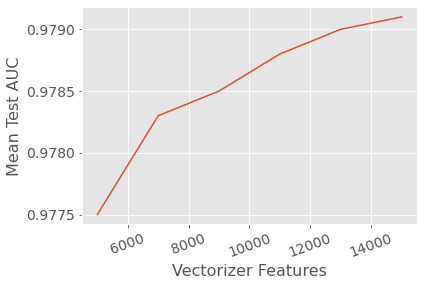

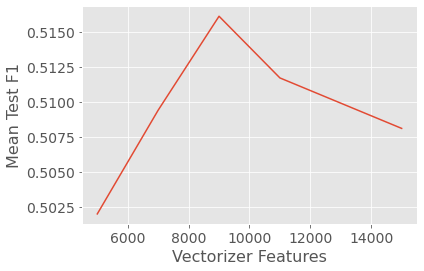

In [377]:
feat = [5000,7000,9000,11000,13000,15000]
test_auc = [0.9775,0.9783,0.9785,0.9788,0.979,0.9791]
test_f1 = [0.502,0.5094,0.5161,0.5117,0.5099,0.5081]
data = pd.DataFrame([feat,test_auc,test_f1]).T.rename(columns={0:'Vectorizer Features',1:'Mean Test AUC',2:'Mean Test F1'}).set_index(['Vectorizer Features'])
plt.xticks(rotation=20)
sns.lineplot(x=data.index,y='Mean Test AUC',data=data)
plt.figure()
sns.lineplot(x=data.index,y='Mean Test F1',data=data)

No significant change between increasing the number of vectorizer features

In [318]:
params = {'n_estimators':[100,200,350,500],'learning_rate':[0.075,0.1,0.2],'num_leaves':[10,31,50]}
model = LGBMClassifier()
grid = GridSearchCV(estimator=model,cv=3,param_grid=params,verbose=5,scoring='roc_auc')
results_count_lgbm = clf_mod(df_test,model=grid,count=True,tfidf=False,max_f=7000,grid=True)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.935, total=   6.5s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.938, total=   6.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.938, total=   6.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.8s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.951, total=   7.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.8s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.955, total=   7.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.956, total=   6.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.954, total=   8.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.959, total=  11.4s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.960, total=  10.7s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10, score=0.946, total=   8.2s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10,

[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.952, total=   7.2s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.959, total=   7.1s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.960, total=   7.6s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.953, total=   8.2s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.961, total=  14.3s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.960, total=   9.8s
[CV] learning_rate=0.2, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.2, n_estimators=200, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 15.1min finished


LGBMClassifier(learning_rate=0.08, n_estimators=200, num_leaves=50)

Label:  toxic , Train Set- AUC:  0.9849 , F1:  0.8134
Label:  toxic , Test Set- AUC:  0.9677 , F1:  0.7595
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.979, total=   6.3s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.976, total=   7.0s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.983, total=   6.4s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.8s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.980, total=   7.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.6s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.976, total=   7.8s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.983, total=  13.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.979, total=   8.8s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.975, total=   8.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.982, total=   7.6s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10, score=0.979, total=   6.7s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10,

[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.970, total=   6.7s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.918, total=   7.0s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.961, total=   6.8s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.963, total=   7.4s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.900, total=   7.2s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.942, total=   7.5s
[CV] learning_rate=0.2, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.2, n_estimators=200, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 11.8min finished


LGBMClassifier(learning_rate=0.08, n_estimators=200, num_leaves=10)

Label:  severe_toxic , Train Set- AUC:  0.9923 , F1:  0.3947
Label:  severe_toxic , Test Set- AUC:  0.9732 , F1:  0.3115
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.978, total=   5.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.978, total=   5.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.978, total=   5.7s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.4s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.983, total=   6.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.3s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.984, total=   7.4s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.982, total=   7.0s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.983, total=   7.8s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.985, total=   7.8s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.983, total=   8.0s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10, score=0.981, total=   6.7s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10,

[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.981, total=   7.0s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.982, total=   7.2s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.978, total=   8.0s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.980, total=   8.5s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.981, total=   8.1s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.977, total=   8.1s
[CV] learning_rate=0.2, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.2, n_estimators=200, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 12.3min finished


LGBMClassifier(learning_rate=0.08, num_leaves=50)

Label:  obscene , Train Set- AUC:  0.9934 , F1:  0.8523
Label:  obscene , Test Set- AUC:  0.9852 , F1:  0.8071
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.939, total=   5.6s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.945, total=   5.8s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.946, total=   5.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.934, total=   6.8s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.1s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.942, total=   6.7s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.947, total=   6.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.927, total=   7.7s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.946, total=   7.7s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.961, total=   7.8s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10, score=0.945, total=   6.6s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10,

[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.627, total=   6.9s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.736, total=   6.4s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.562, total=   6.4s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.628, total=   7.4s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.780, total=   7.3s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.657, total=   7.5s
[CV] learning_rate=0.2, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.2, n_estimators=200, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 11.7min finished


LGBMClassifier(learning_rate=0.08, n_estimators=350, num_leaves=10)

Label:  threat , Train Set- AUC:  0.9995 , F1:  0.77
Label:  threat , Test Set- AUC:  0.9456 , F1:  0.2714
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.964, total=   5.6s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.959, total=   5.8s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.965, total=   5.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.972, total=   7.3s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.6s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.969, total=   7.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.971, total=   7.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.973, total=   8.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.970, total=   8.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.973, total=   8.1s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10, score=0.969, total=   6.7s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10,

[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.972, total=   7.0s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.967, total=   7.0s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.970, total=   7.0s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.972, total=   8.1s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.967, total=   7.9s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.968, total=   7.9s
[CV] learning_rate=0.2, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.2, n_estimators=200, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 12.4min finished


LGBMClassifier(learning_rate=0.08, n_estimators=200, num_leaves=50)

Label:  insult , Train Set- AUC:  0.9916 , F1:  0.8031
Label:  insult , Test Set- AUC:  0.9722 , F1:  0.7007
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.958, total=   5.7s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.968, total=   5.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=10 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=10, score=0.962, total=   6.0s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.963, total=   7.0s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.7s remaining:    0.0s


[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.970, total=   6.9s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=31 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=31, score=0.968, total=   7.1s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.961, total=   8.0s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.967, total=   8.0s
[CV] learning_rate=0.08, n_estimators=100, num_leaves=50 .............
[CV]  learning_rate=0.08, n_estimators=100, num_leaves=50, score=0.966, total=   8.0s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10, score=0.956, total=   6.9s
[CV] learning_rate=0.08, n_estimators=200, num_leaves=10 .............
[CV]  learning_rate=0.08, n_estimators=200, num_leaves=10,

[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.849, total=   6.8s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.902, total=   6.7s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=31 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=31, score=0.935, total=   6.9s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.930, total=   7.8s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.931, total=   7.8s
[CV] learning_rate=0.2, n_estimators=100, num_leaves=50 ..............
[CV]  learning_rate=0.2, n_estimators=100, num_leaves=50, score=0.908, total=   8.1s
[CV] learning_rate=0.2, n_estimators=200, num_leaves=10 ..............
[CV]  learning_rate=0.2, n_estimators=200, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 12.2min finished


LGBMClassifier(learning_rate=0.08)

Label:  identity_hate , Train Set- AUC:  0.9951 , F1:  0.6159
Label:  identity_hate , Test Set- AUC:  0.9651 , F1:  0.3411

Mean Train AUC:  0.9928 Mean Train Macro F1:  0.7082
Mean Test AUC:  0.9681 Mean Test Macro F1:  0.5319
Test Hamming Loss:  0.018
Test Accuracy Score (Exact Match):  0.8971


In [320]:
pd.DataFrame(results_count)

,Train_AUC,Test_AUC,Train_f1,Test_f1,Mean_Train_AUC,Mean_Test_AUC,Mean_Train_F1,Mean_Test_F1,Test Hamming Loss,Test Accuracy Score,Grid Parameters
0,0.984856,0.967685,0.813414,0.759503,0.9928,0.9681,0.7082,0.5319,0.018,0.8971,"{'learning_rate': 0.08, 'n_estimators': 200, '..."
1,0.992333,0.973161,0.394737,0.311512,0.9928,0.9681,0.7082,0.5319,0.018,0.8971,"{'learning_rate': 0.08, 'n_estimators': 200, '..."
2,0.993407,0.985214,0.852266,0.807127,0.9928,0.9681,0.7082,0.5319,0.018,0.8971,"{'learning_rate': 0.08, 'n_estimators': 100, '..."
3,0.999488,0.945559,0.769953,0.271429,0.9928,0.9681,0.7082,0.5319,0.018,0.8971,"{'learning_rate': 0.08, 'n_estimators': 350, '..."
4,0.991638,0.972152,0.803073,0.700725,0.9928,0.9681,0.7082,0.5319,0.018,0.8971,"{'learning_rate': 0.08, 'n_estimators': 200, '..."
5,0.995054,0.965053,0.615913,0.341085,0.9928,0.9681,0.7082,0.5319,0.018,0.8971,"{'learning_rate': 0.08, 'n_estimators': 100, '..."


Labels threat and identity hate seem to be overfitting on the optimized gridsearch test. These can be resampled with SMOTE to check for improvements

No significant changes seen with increasing feature size.  <br> Next, use pretrained word vector models word2vec and glove with Logistic Regression and Light Gradient Boost Classifier.

In [396]:
def mean_embd(model,comment,avg):
    '''
    This function takes in the pretrained word model and comment 
       tokens to create a comment vector by averaging the word vectors
       
    Words not found in the word vector model as well as empty comments
    have been replaced by an average of the word vectors in the model.
    Ref1: https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt
    Ref2: https://groups.google.com/g/globalvectors/c/9w8ZADXJclA/m/hRdn4prm-XUJ
    '''
    #word_vec = [model[w] for w in comment if w in model.vocab else avg]
    #words = [word for word in comment if word in model.vocab]
    
    #Replace words not in pretained model with an average model vector
    word_vec = [model[w] if w in model.vocab else avg for w in comment]
    #coverage = [1 if w in model.vocab else 0 for w in comment]
    #Return comments that contain atleast one token
    if len(word_vec)>=1:
        return np.mean(word_vec,axis=0)
    #    return np.mean(model[words],axis=0)
    else:
        #Return average model vector if comment is empty
        return avg
    
def create_features(df,model,avg):
    '''
    This function takes in the dataframe and word model (glove or word2vec) 
    to return mean embeddings for each comment.
    '''
    df_X = df['tokens'].apply(lambda a: mean_embd(model,a,avg))
    X = pd.DataFrame(dict(zip(df_X.index,df_X.values))).T
    print(X.isna().any(axis=1).sum())
    print(X.shape, X.dropna().shape)
    y_all = df[labels]
    y_all = pd.concat([X,y_all],axis=1).dropna()[labels]
    X = X.dropna()
    return X, y_all

In [403]:
def clf_mod_emb(X,y_all,model,resample_all=False,resample_sub=False,grid=False):
    auc, auc_tr = [], []
    f1, f1_tr = [], []
    #pred, tr_pred = [], []
    #pred_prob, tr_pred_prob = [], []
    Test, Test_pred, Test_prob = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    grid_params = []
    for a in labels:
        
        y = y_all[a]
        #Random split into training and test data
        X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
        
        y_test_a = pd.DataFrame(y_te.reset_index().drop('index',axis=1))
        Test = pd.concat([Test,y_test_a],axis=1)
        
        #Resampling all or a subset of labels if True
        if resample_all == True:
                X_tr, y_tr = resample_train(X_tr,y_tr,smote=True,undersample=False)
        
        elif resample_sub == True:
            if a in ['severe_toxic','threat','identity_hate']:
                X_tr, y_tr = resample_train(X_tr,y_tr,smote=True)
        
        model.fit(X_tr.astype('float'),y_tr)
        
        if grid == True:
            grid_params.append(model.best_params_)
            print(model.best_estimator_)
        
        y_tr_pred = model.predict(X_tr.astype('float'))
        y_tr_pred_prob = model.predict_proba(X_tr.astype('float'))
        y_te_pred = model.predict(X_te.astype('float'))
        y_te_pred_prob = model.predict_proba(X_te.astype('float'))
        
        #pred.append((a+'_test_pred',y_te_pred))
        
        pred_a = pd.DataFrame(y_te_pred).rename(columns={0:(a+'_test_pred')}).reset_index().drop('index',axis=1)
        Test_pred = pd.concat([Test_pred,pred_a],axis=1)
        
        pred_prob_a = pd.DataFrame(y_te_pred_prob).rename(columns={0:(a+'_0_prob'),1:(a+'_1_prob')}).reset_index().drop('index',axis=1)
        Test_prob = pd.concat([Test_prob,pred_prob_a],axis=1)
        
        #pred_prob.append((a+'_test_pred_prob',y_te_pred_prob))
        #tr_pred.append((a+'_train_pred',y_tr_pred))
        #tr_pred_prob.append((a+'_train_pred_prob',y_tr_pred_prob))
        
        auc_sc = roc_auc_score(y_te,y_te_pred_prob[:,1])
        f1_sc = f1_score(y_te,y_te_pred)
        auc.append(auc_sc)
        f1.append(f1_sc)
        
        auc_sc_tr = roc_auc_score(y_tr,y_tr_pred_prob[:,1])
        f1_sc_tr = f1_score(y_tr,y_tr_pred)
        auc_tr.append(auc_sc_tr)
        f1_tr.append(f1_sc_tr)
        
        print('\nLabel: ',a,', Train Set- AUC: ',round(auc_sc_tr,4),', F1: ',round(f1_sc_tr,4))
        print('Label: ',a,', Test Set- AUC: ',round(auc_sc,4),', F1: ',round(f1_sc,4))
        #model_metrics(y_te,y_te_pred,y_te_pred_prob,title=a)
    
    auc_m_tr = round(np.mean(auc_tr),4)
    f1_m_tr = round(np.mean(f1_tr),4)
    auc_m_te = round(np.mean(auc),4)
    f1_m_te = round(np.mean(f1),4)
    hm_l = round(hamming_loss(Test,Test_pred),4)
    ac_sc = round(accuracy_score(Test,Test_pred),4)
    
    print('\nMean Train AUC: ',auc_m_tr,'Train Macro F1: ',f1_m_tr)
    print('Mean Test AUC: ',auc_m_te,'Test Macro F1: ',f1_m_te)
    print('Test Hamming Loss: ', hm_l)
    print('Test Accuracy Score (Exact Match): ', ac_sc)
    
    return {'Train_AUC':auc_tr,'Test_AUC':auc,
            'Train_f1':f1_tr,'Test_f1':f1,
            'Mean_Train_AUC':auc_m_tr,'Mean_Test_AUC':auc_m_te,
            'Mean_Train_f1':f1_m_tr,'Mean_Test_f1':f1_m_te,
            'Test Hamming Loss':hm_l, 'Test Accuracy Score': ac_sc,'Grid Parameters':grid_params}



    return {'Train_AUC':auc_tr,'Test_AUC':auc,
            'Train_f1':f1_tr,'Test_f1':f1,
            'Mean_Train_AUC':auc_m_tr,'Mean_Test_AUC':auc_m_te,
            'Mean_Train_F1':f1_m_tr,'Mean_Test_F1':f1_m_te,
            'Test Hamming Loss':hm_l, 'Test Accuracy Score': ac_sc,'Grid Parameters':grid_params}

Create average comment vectors using word2vec and glove models

In [122]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# # glove_input = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove/glove.6B.300d.txt'
# # w2v_output = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove/glove.6B.300d_w2v.txt'
# # glove2word2vec(glove_input,w2v_output)

# # glove_tw_input = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove_tweet/glove.twitter.27B.200d.txt'
# # w2v_tw_output = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove_tweet/glove.twitter.27B.200d_w2v.txt'
# # glove2word2vec(glove_tw_input,w2v_tw_output)

# # #Load pretrained glove model
# # file = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove/glove.6B.300d_w2v.txt'
# # mod_glove = gm.models.KeyedVectors.load_word2vec_format(file, binary=False)
# file_tw = '/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/glove_tweet/glove.twitter.27B.200d_w2v.txt'
# mod_glove_tw = gm.models.KeyedVectors.load_word2vec_format(file_tw,binary=False)

# # #Load pretrained word2vec model
# # mod_w2v = gm.models.KeyedVectors.load_word2vec_format('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #3/GoogleNews-vectors-negative300.bin', binary=True) 

# # #Load pretrained fasttext model
# #  fasttext = gm.models.KeyedVectors.load_word2vec_format('/Users/shaunakphatak/Downloads/crawl-300d-2M.vec')

# # # #Save models for later use
# # gl_p = gm.utils.SaveLoad.save(mod_glove,'glove_300')
# # w2v_p = gm.utils.SaveLoad.save(mod_w2v,'w2v_300')
# gl_tw_p = gm.utils.SaveLoad.save(mod_glove_tw,'glove_tw_200')
# # gl_p = mod_glove.save('glove_300.pkl')
# # w2v_p = mod_w2v.save('w2v_300.pkl')
# #fast_p = fasttext = gm.utils.SaveLoad.save(fasttext,'fast_300')

In [399]:
mod_glove = gm.utils.SaveLoad.load('glove_300')
mod_w2v = gm.utils.SaveLoad.load('w2v_300')
# mod_glove_tw = gm.utils.SaveLoad.load('glove_tw_200')
#mod_fast = gm.utils.SaveLoad.load('fast_300')

#Averaged vector of all vocabulary in word2vec and glove to replace unknown words and empty comments in the corpus
avgvec_gl = np.mean([mod_glove[w] for w in mod_glove.vocab],axis=0)
# avgvec_gl_tw = np.mean([mod_glove_tw[w] for w in mod_glove_tw.vocab],axis=0)
avgvec_w2v = np.mean([mod_w2v[w] for w in mod_w2v.vocab],axis=0)
#avgvec_fst = np.mean([mod_fast[w] for w in mod_fast.vocab],axis=0)
#pickle.dump(avgvec_fst, open("avgvec_fst", "wb"))

X_glove, y_all_glove = create_features(df_test,mod_glove,avgvec_gl)
# X_glove_tw, y_all_glove_tw = create_features(df_test,mod_glove_tw,avgvec_gl_tw)
X_w2v, y_all_w2v = create_features(df_test,mod_w2v,avgvec_w2v)
#X_fast, y_all_fast = create_features(df_test,mod_fast,avgvec_fst)

0
(159571, 300) (159571, 300)
0
(159571, 300) (159571, 300)


Running models Logistic Regression and Light Gradient Boost with word2vec, glove averaged vectors with/without resampling

In [410]:
#Word2Vec Embedding without resampling
model = LogisticRegression(max_iter=100000)
w2v_logreg = clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9531 , F1:  0.6531
Label:  toxic , Test Set- AUC:  0.956 , F1:  0.6558

Label:  severe_toxic , Train Set- AUC:  0.979 , F1:  0.2893
Label:  severe_toxic , Test Set- AUC:  0.9775 , F1:  0.3243

Label:  obscene , Train Set- AUC:  0.968 , F1:  0.6584
Label:  obscene , Test Set- AUC:  0.967 , F1:  0.6496

Label:  threat , Train Set- AUC:  0.977 , F1:  0.1565
Label:  threat , Test Set- AUC:  0.9637 , F1:  0.15

Label:  insult , Train Set- AUC:  0.9608 , F1:  0.5224
Label:  insult , Test Set- AUC:  0.9565 , F1:  0.5113

Label:  identity_hate , Train Set- AUC:  0.9644 , F1:  0.2214
Label:  identity_hate , Test Set- AUC:  0.958 , F1:  0.1739

Mean Train AUC:  0.9671 Train Macro F1:  0.4169
Mean Test AUC:  0.9631 Test Macro F1:  0.4108
Test Hamming Loss:  0.0243
Test Accuracy Score (Exact Match):  0.8626


In [411]:
#Word2Vec Embedding with resampling
model = LogisticRegression(max_iter=100000)
w2v_logreg_resamp = clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115421, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115421, 1: 46168})

Label:  toxic , Train Set- AUC:  0.9581 , F1:  0.8089
Label:  toxic , Test Set- AUC:  0.9567 , F1:  0.6915
Pre-resampling  Counter({0: 126380, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126380, 1: 50552})

Label:  severe_toxic , Train Set- AUC:  0.9835 , F1:  0.8935
Label:  severe_toxic , Test Set- AUC:  0.9803 , F1:  0.3267
Pre-resampling  Counter({0: 120897, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120897, 1: 48358})

Label:  obscene , Train Set- AUC:  0.9726 , F1:  0.8475
Label:  obscene , Test Set- AUC:  0.9683 , F1:  0.6513
Pre-resampling  Counter({0: 127274, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127274, 1: 50909})

Label:  threat , Train Set- AUC:  0.9841 , F1:  0.9067
Label:  threat , Test Set- AUC:  0.9606 , F1:  0.1046
Pre-resampling  Counter({0: 121354, 1: 6302})
Oversampling (

In [412]:
#Word2Vec Embedding without resampling
model = LGBMClassifier()
w2v_lgbm = clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9782 , F1:  0.7592
Label:  toxic , Test Set- AUC:  0.9577 , F1:  0.697

Label:  severe_toxic , Train Set- AUC:  0.9999 , F1:  0.9598
Label:  severe_toxic , Test Set- AUC:  0.9819 , F1:  0.3124

Label:  obscene , Train Set- AUC:  0.995 , F1:  0.8221
Label:  obscene , Test Set- AUC:  0.9725 , F1:  0.7116

Label:  threat , Train Set- AUC:  0.9701 , F1:  0.8832
Label:  threat , Test Set- AUC:  0.8138 , F1:  0.1394

Label:  insult , Train Set- AUC:  0.9922 , F1:  0.7472
Label:  insult , Test Set- AUC:  0.9606 , F1:  0.6042

Label:  identity_hate , Train Set- AUC:  0.9999 , F1:  0.9775
Label:  identity_hate , Test Set- AUC:  0.9578 , F1:  0.2823

Mean Train AUC:  0.9892 Train Macro F1:  0.8582
Mean Test AUC:  0.9407 Test Macro F1:  0.4578
Test Hamming Loss:  0.0234
Test Accuracy Score (Exact Match):  0.8672


In [413]:
#Word2Vec Embedding with resampling (ADDED average model vector for unknown and empty comments)
model = LGBMClassifier()
w2v_lgbm_resamp = clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115421, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115421, 1: 46168})

Label:  toxic , Train Set- AUC:  0.9838 , F1:  0.8887
Label:  toxic , Test Set- AUC:  0.955 , F1:  0.7041
Pre-resampling  Counter({0: 126380, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126380, 1: 50552})

Label:  severe_toxic , Train Set- AUC:  0.9989 , F1:  0.985
Label:  severe_toxic , Test Set- AUC:  0.9845 , F1:  0.4469
Pre-resampling  Counter({0: 120897, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120897, 1: 48358})

Label:  obscene , Train Set- AUC:  0.9952 , F1:  0.9421
Label:  obscene , Test Set- AUC:  0.9703 , F1:  0.7112
Pre-resampling  Counter({0: 127274, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127274, 1: 50909})

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9973
Label:  threat , Test Set- AUC:  0.9653 , F1:  0.3789
Pre-resampling  Counter({0: 121354, 1: 6302})
Oversampling (SMOTE

In [414]:
#Glove Embedding without resampling
model = LogisticRegression(max_iter=100000)
glove_logreg = clf_mod_emb(X_glove,y_all_glove,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9431 , F1:  0.6313
Label:  toxic , Test Set- AUC:  0.9473 , F1:  0.6379

Label:  severe_toxic , Train Set- AUC:  0.9781 , F1:  0.286
Label:  severe_toxic , Test Set- AUC:  0.9743 , F1:  0.3216

Label:  obscene , Train Set- AUC:  0.9623 , F1:  0.6584
Label:  obscene , Test Set- AUC:  0.96 , F1:  0.652

Label:  threat , Train Set- AUC:  0.9735 , F1:  0.1771
Label:  threat , Test Set- AUC:  0.9637 , F1:  0.1613

Label:  insult , Train Set- AUC:  0.9552 , F1:  0.5159
Label:  insult , Test Set- AUC:  0.953 , F1:  0.5124

Label:  identity_hate , Train Set- AUC:  0.9646 , F1:  0.2394
Label:  identity_hate , Test Set- AUC:  0.9612 , F1:  0.2271

Mean Train AUC:  0.9628 Train Macro F1:  0.418
Mean Test AUC:  0.9599 Test Macro F1:  0.4187
Test Hamming Loss:  0.0246
Test Accuracy Score (Exact Match):  0.8609


In [415]:
#Glove Embedding with resampling
model = LogisticRegression(max_iter=100000)
glove_logreg_resamp = clf_mod_emb(X_glove,y_all_glove,model,resample_all = True,resample_sub=False)

Pre-resampling  Counter({0: 115421, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115421, 1: 46168})

Label:  toxic , Train Set- AUC:  0.9488 , F1:  0.7845
Label:  toxic , Test Set- AUC:  0.9478 , F1:  0.664
Pre-resampling  Counter({0: 126380, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126380, 1: 50552})

Label:  severe_toxic , Train Set- AUC:  0.9824 , F1:  0.891
Label:  severe_toxic , Test Set- AUC:  0.9782 , F1:  0.3114
Pre-resampling  Counter({0: 120897, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120897, 1: 48358})

Label:  obscene , Train Set- AUC:  0.968 , F1:  0.834
Label:  obscene , Test Set- AUC:  0.9616 , F1:  0.6341
Pre-resampling  Counter({0: 127274, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127274, 1: 50909})

Label:  threat , Train Set- AUC:  0.9813 , F1:  0.8876
Label:  threat , Test Set- AUC:  0.9635 , F1:  0.1014
Pre-resampling  Counter({0: 121354, 1: 6302})
Oversampling (SMOT

In [416]:
#Glove Embedding without resampling
model = LGBMClassifier()
glove_lgbm = clf_mod_emb(X_glove,y_all_glove,model,resample_all=False,resample_sub=False)


Label:  toxic , Train Set- AUC:  0.9733 , F1:  0.7371
Label:  toxic , Test Set- AUC:  0.9471 , F1:  0.6657

Label:  severe_toxic , Train Set- AUC:  0.9999 , F1:  0.956
Label:  severe_toxic , Test Set- AUC:  0.9774 , F1:  0.3364

Label:  obscene , Train Set- AUC:  0.9936 , F1:  0.8061
Label:  obscene , Test Set- AUC:  0.9657 , F1:  0.7029

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9896
Label:  threat , Test Set- AUC:  0.9018 , F1:  0.144

Label:  insult , Train Set- AUC:  0.9908 , F1:  0.7357
Label:  insult , Test Set- AUC:  0.9566 , F1:  0.5866

Label:  identity_hate , Train Set- AUC:  1.0 , F1:  0.9861
Label:  identity_hate , Test Set- AUC:  0.9667 , F1:  0.2768

Mean Train AUC:  0.9929 Train Macro F1:  0.8684
Mean Test AUC:  0.9525 Test Macro F1:  0.4521
Test Hamming Loss:  0.0235
Test Accuracy Score (Exact Match):  0.866


In [417]:
#Glove Embedding with resampling
model = LGBMClassifier()
glove_lgbm_resamp = clf_mod_emb(X_glove,y_all_glove,model,resample_all=True,resample_sub=False)

Pre-resampling  Counter({0: 115421, 1: 12235})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 115421, 1: 46168})

Label:  toxic , Train Set- AUC:  0.9794 , F1:  0.8745
Label:  toxic , Test Set- AUC:  0.9441 , F1:  0.6781
Pre-resampling  Counter({0: 126380, 1: 1276})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 126380, 1: 50552})

Label:  severe_toxic , Train Set- AUC:  0.9988 , F1:  0.984
Label:  severe_toxic , Test Set- AUC:  0.9826 , F1:  0.4484
Pre-resampling  Counter({0: 120897, 1: 6759})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 120897, 1: 48358})

Label:  obscene , Train Set- AUC:  0.9941 , F1:  0.9366
Label:  obscene , Test Set- AUC:  0.9672 , F1:  0.6978
Pre-resampling  Counter({0: 127274, 1: 382})
Oversampling (SMOTE) Class 1 = 0.4X Class 0  Counter({0: 127274, 1: 50909})

Label:  threat , Train Set- AUC:  0.9999 , F1:  0.9965
Label:  threat , Test Set- AUC:  0.9614 , F1:  0.381
Pre-resampling  Counter({0: 121354, 1: 6302})
Oversampling (SM

In [427]:
params = {'penalty':['l2'],'C':[0.05,0.1,1,5,10,50],'solver':['newton-cg', 'lbfgs', 'liblinear']}
model = LogisticRegression(max_iter=100000)
grid = GridSearchCV(estimator=model,cv=3,param_grid=params,verbose=5,scoring='roc_auc')
results_w2v_grid_log = clf_mod_emb(X_w2v,y_all_w2v,model=grid,resample_all=False,resample_sub=False,grid=True)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.945, total=   6.1s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.950, total=   6.7s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.8s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.946, total=   4.9s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.7s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.945, total=   1.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.9s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.950, total=   1.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.946, total=   1.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.945, total=   3.4s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.950, total=   3.8s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.946, total=   3.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.948, total=   6.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.952, total=   5.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  4.8min finished


LogisticRegression(C=1, max_iter=100000, solver='newton-cg')

Label:  toxic , Train Set- AUC:  0.9531 , F1:  0.6531
Label:  toxic , Test Set- AUC:  0.956 , F1:  0.6558
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.974, total=   4.9s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.974, total=   5.2s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.977, total=   5.4s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.5s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.974, total=   1.0s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.5s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.974, total=   0.9s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.977, total=   1.1s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.976, total=   3.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.976, total=   3.5s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.977, total=   3.5s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.976, total=   6.3s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.976, total=   5.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  4.9min finished


LogisticRegression(C=0.1, max_iter=100000, solver='liblinear')

Label:  severe_toxic , Train Set- AUC:  0.9785 , F1:  0.2334
Label:  severe_toxic , Test Set- AUC:  0.9783 , F1:  0.2679
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.962, total=   6.3s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.962, total=   5.9s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.961, total=   5.1s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.4s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.962, total=   1.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.6s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.962, total=   1.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.961, total=   1.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.963, total=   3.8s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.962, total=   3.8s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.962, total=   3.9s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.965, total=   5.3s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.964, total=  10.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  5.2min finished


LogisticRegression(C=1, max_iter=100000, solver='newton-cg')

Label:  obscene , Train Set- AUC:  0.968 , F1:  0.6584
Label:  obscene , Test Set- AUC:  0.967 , F1:  0.6496
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.963, total=   4.6s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.966, total=   4.6s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.965, total=   5.0s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.3s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.963, total=   1.3s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.7s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.966, total=   3.5s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.965, total=   2.9s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.949, total=   5.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.960, total=   5.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.960, total=   2.9s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.967, total=   5.0s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.969, total=   5.9s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  5.2min finished


LogisticRegression(C=1, max_iter=100000)

Label:  threat , Train Set- AUC:  0.977 , F1:  0.1565
Label:  threat , Test Set- AUC:  0.9637 , F1:  0.15
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.955, total=   5.3s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.957, total=   4.7s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.955, total=   8.8s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.9s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.955, total=   2.6s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.5s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.957, total=   2.5s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.955, total=   3.7s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.956, total=  10.6s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.957, total=   7.0s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.955, total=   4.9s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.958, total=   8.2s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.959, total=   5.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  5.0min finished


LogisticRegression(C=1, max_iter=100000, solver='newton-cg')

Label:  insult , Train Set- AUC:  0.9608 , F1:  0.5224
Label:  insult , Test Set- AUC:  0.9565 , F1:  0.5111
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.953, total=   7.7s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.957, total=   5.0s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.957, total=   4.8s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.5s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.953, total=   1.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.7s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.957, total=   1.0s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.957, total=   1.0s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.952, total=   3.0s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.957, total=   2.8s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.957, total=   2.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.955, total=   4.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.959, total=   5.5s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  4.5min finished


LogisticRegression(C=1, max_iter=100000)

Label:  identity_hate , Train Set- AUC:  0.9644 , F1:  0.2214
Label:  identity_hate , Test Set- AUC:  0.958 , F1:  0.1739

Mean Train AUC:  0.967 Train Macro F1:  0.4075
Mean Test AUC:  0.9633 Test Macro F1:  0.4014
Test Hamming Loss:  0.0243
Test Accuracy Score (Exact Match):  0.8624


In [428]:
params = {'n_estimators':[100,200,350,500],'learning_rate':[0.075,0.1,0.2],'num_leaves':[10,31,50]}
model = LGBMClassifier()
grid = GridSearchCV(estimator=model,cv=3,param_grid=params,verbose=5,scoring='roc_auc')
results_w2v_grid_lgbm = clf_mod_emb(X_w2v,y_all_w2v,model=grid,resample_all=False,resample_sub=False,grid=True)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.944, total=   8.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.948, total=   8.4s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.1s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.943, total=   8.2s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.4s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.948, total=  11.1s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.5s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.953, total=  10.8s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.948, total=  10.9s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.950, total=  12.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.954, total=  11.9s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.950, total=  12.7s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.952, total=  12.0s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.955, total=  23.0s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.959, total=  23.1s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.956, total=  23.4s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.957, total=  30.4s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.960, total=  30.6s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.956, total=  30.4s
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 37.7min finished


LGBMClassifier(learning_rate=0.075, n_estimators=500, num_leaves=50)

Label:  toxic , Train Set- AUC:  0.9999 , F1:  0.9886
Label:  toxic , Test Set- AUC:  0.9635 , F1:  0.7261
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.976, total=   6.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.979, total=   6.8s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.979, total=   6.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.1s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.975, total=   9.3s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.4s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.978, total=   9.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.979, total=   9.7s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.976, total=  11.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.979, total=  11.1s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.979, total=  11.6s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.976, total=   9.9s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.977, total=  22.6s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.975, total=  22.9s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.979, total=  22.2s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.978, total=  28.6s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.975, total=  31.0s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.977, total=13.5min
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 45.4min finished


LGBMClassifier(learning_rate=0.075, n_estimators=200, num_leaves=50)

Label:  severe_toxic , Train Set- AUC:  1.0 , F1:  0.9768
Label:  severe_toxic , Test Set- AUC:  0.9844 , F1:  0.3189
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.966, total=   7.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.966, total=   7.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.966, total=   6.9s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.969, total=   9.3s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.8s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.970, total=   8.9s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.968, total=   9.4s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.970, total=  11.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.969, total=  11.1s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.969, total=  10.7s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.971, total=  10.3s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.974, total=  22.8s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.972, total=  22.9s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.972, total=  23.1s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.975, total=  30.2s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.974, total=  29.3s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.974, total=  30.3s
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 36.9min finished


LGBMClassifier(n_estimators=500, num_leaves=50)

Label:  obscene , Train Set- AUC:  1.0 , F1:  0.9969
Label:  obscene , Test Set- AUC:  0.9773 , F1:  0.7401
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.936, total=   8.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.946, total=  10.1s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.7s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.947, total=   8.9s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.908, total=  11.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.8s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.950, total=  13.8s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.926, total=  12.2s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.937, total=  19.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.937, total=  18.8s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.934, total=  16.2s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.941, total=  12.0s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

KeyboardInterrupt: 

In [424]:
params = {'penalty':['l2'],'C':[0.05,0.1,1,5,10,50],'solver':['newton-cg', 'lbfgs', 'liblinear']}
model = LogisticRegression(max_iter=100000)
grid = GridSearchCV(estimator=model,cv=3,param_grid=params,verbose=5,scoring='roc_auc')
results_glove_grid_log = clf_mod_emb(X_glove,y_all_glove,model=grid,resample_all=False,resample_sub=False,grid=True)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.938, total=   6.0s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.943, total=   5.4s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.940, total=   5.6s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.0s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.938, total=   1.4s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.4s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.943, total=   1.4s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.940, total=   1.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.938, total=   4.9s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.943, total=   4.7s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.940, total=   4.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.938, total=   6.3s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.943, total=   6.3s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.7min finished


LogisticRegression(C=1, max_iter=100000, solver='liblinear')

Label:  toxic , Train Set- AUC:  0.9431 , F1:  0.6314
Label:  toxic , Test Set- AUC:  0.9473 , F1:  0.6385
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.975, total=   4.8s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.976, total=   4.4s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.977, total=   4.4s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.7s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.975, total=   1.1s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.8s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.976, total=   1.1s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.977, total=   1.0s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.973, total=   4.0s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.973, total=   3.7s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.974, total=   3.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.975, total=   5.2s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.976, total=   5.1s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.3min finished


LogisticRegression(C=0.1, max_iter=100000)

Label:  severe_toxic , Train Set- AUC:  0.978 , F1:  0.2698
Label:  severe_toxic , Test Set- AUC:  0.9756 , F1:  0.3136
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.961, total=   5.3s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.961, total=   5.1s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.957, total=   4.7s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.1s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.961, total=   1.4s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.5s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.961, total=   1.5s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.957, total=   1.4s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.961, total=   4.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.961, total=   4.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.957, total=   4.2s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.961, total=   5.2s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.961, total=   5.7s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.4min finished


LogisticRegression(C=0.1, max_iter=100000, solver='liblinear')

Label:  obscene , Train Set- AUC:  0.9617 , F1:  0.6383
Label:  obscene , Test Set- AUC:  0.9598 , F1:  0.6324
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.968, total=   4.5s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.967, total=   4.3s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.965, total=   4.5s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.968, total=   1.0s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.5s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.967, total=   1.0s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.965, total=   1.1s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.954, total=   3.5s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.950, total=   3.5s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.948, total=   3.5s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.970, total=   5.2s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.968, total=   5.1s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  5.7min finished


LogisticRegression(C=0.1, max_iter=100000)

Label:  threat , Train Set- AUC:  0.9724 , F1:  0.1131
Label:  threat , Test Set- AUC:  0.9624 , F1:  0.1416
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.950, total=   5.1s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.953, total=   4.9s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.954, total=   4.9s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.9s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.950, total=   1.4s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.4s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.953, total=   1.4s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.954, total=   1.4s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.949, total=   4.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.952, total=   4.3s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.953, total=   3.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.950, total=   5.3s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.953, total=   5.4s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.3min finished


LogisticRegression(C=0.1, max_iter=100000)

Label:  insult , Train Set- AUC:  0.9543 , F1:  0.5058
Label:  insult , Test Set- AUC:  0.953 , F1:  0.5027
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.961, total=   4.7s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.962, total=   5.2s
[CV] C=0.05, penalty=l2, solver=newton-cg ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


[CV]  C=0.05, penalty=l2, solver=newton-cg, score=0.961, total=   5.1s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.0s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.961, total=   1.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.2s remaining:    0.0s


[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.962, total=   1.2s
[CV] C=0.05, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.05, penalty=l2, solver=lbfgs, score=0.961, total=   1.2s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.956, total=   3.7s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.958, total=   3.6s
[CV] C=0.05, penalty=l2, solver=liblinear ............................
[CV]  C=0.05, penalty=l2, solver=liblinear, score=0.956, total=   3.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.962, total=   4.8s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] . C=0.1, penalty=l2, solver=newton-cg, score=0.962, total=   5.6s
[CV] C=0.1, penalty=l2, solver=newton-cg .............................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.2min finished


LogisticRegression(C=0.1, max_iter=100000)

Label:  identity_hate , Train Set- AUC:  0.9646 , F1:  0.192
Label:  identity_hate , Test Set- AUC:  0.9618 , F1:  0.1948

Mean Train AUC:  0.9624 Train Macro F1:  0.3917
Mean Test AUC:  0.96 Test Macro F1:  0.4039
Test Hamming Loss:  0.0247
Test Accuracy Score (Exact Match):  0.8603


In [426]:
results_w2v_grid_log

{'Train_AUC': [0.9431419973885903,
  0.9780446813883193,
  0.9616640786429572,
  0.972397145886432,
  0.9543480330765064,
  0.9646286430236994],
 'Test_AUC': [0.9473115220912299,
  0.9755660809411612,
  0.9598314221249897,
  0.9623763841310746,
  0.9529918280649987,
  0.9617987831012941],
 'Train_f1': [0.6314318510755103,
  0.26977803073420603,
  0.638290098648155,
  0.11312217194570136,
  0.5058470454310255,
  0.192],
 'Test_f1': [0.638450788580555,
  0.3135593220338983,
  0.6324167872648335,
  0.1415929203539823,
  0.502695976773123,
  0.1948424068767908],
 'Mean_Train_AUC': 0.9624,
 'Mean_Test_AUC': 0.96,
 'Mean_Train_f1': 0.3917,
 'Mean_Test_f1': 0.4039,
 'Test Hamming Loss': 0.0247,
 'Test Accuracy Score': 0.8603,
 'Grid Parameters': [{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'},
  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'},
  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs

In [425]:
params = {'n_estimators':[100,200,350,500],'learning_rate':[0.075,0.1,0.2],'num_leaves':[10,31,50]}
model = LGBMClassifier()
grid = GridSearchCV(estimator=model,cv=3,param_grid=params,verbose=5,scoring='roc_auc')
results_glove_grid_lgbm = clf_mod_emb(X_glove,y_all_glove,model=grid,resample_all=False,resample_sub=False,grid=True)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.932, total=   7.1s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.935, total=   6.9s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.933, total=   7.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.0s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.938, total=   9.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.5s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.941, total=   9.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.940, total=   9.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.940, total=  11.1s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.943, total=  11.3s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.941, total=  11.2s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.942, total=  10.6s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.947, total=  22.2s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.950, total=  22.4s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.947, total=  22.3s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.948, total=  28.8s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.950, total=  28.9s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.948, total=  29.0s
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 33.9min finished


LGBMClassifier(learning_rate=0.075, n_estimators=500, num_leaves=50)

Label:  toxic , Train Set- AUC:  0.9999 , F1:  0.9798
Label:  toxic , Test Set- AUC:  0.9557 , F1:  0.7017
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.973, total=   6.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.976, total=   6.7s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.978, total=   6.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.9s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.973, total=   8.7s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.7s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.975, total=   8.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.976, total=   8.7s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.973, total=  10.4s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.977, total=  10.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.978, total=  10.2s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.974, total=   9.4s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.973, total=  21.7s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.977, total=  21.5s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.979, total=  21.2s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.977, total=  28.2s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.979, total=  27.6s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.980, total=  27.6s
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 30.8min finished


LGBMClassifier(n_estimators=500, num_leaves=50)

Label:  severe_toxic , Train Set- AUC:  1.0 , F1:  0.9799
Label:  severe_toxic , Test Set- AUC:  0.9815 , F1:  0.3243
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.960, total=   7.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.960, total=   7.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.958, total=   7.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.6s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.963, total=   9.3s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.9s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.964, total=   9.3s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.961, total=   9.2s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.964, total=  10.8s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.966, total=  11.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.962, total=  10.8s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.967, total=  10.5s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.970, total=  22.7s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.971, total=  23.5s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.967, total=  22.9s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.971, total=  29.8s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.972, total=  29.9s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.969, total=  29.9s
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 34.1min finished


LGBMClassifier(n_estimators=500, num_leaves=50)

Label:  obscene , Train Set- AUC:  1.0 , F1:  0.9969
Label:  obscene , Test Set- AUC:  0.9736 , F1:  0.7288
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.910, total=   6.4s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.933, total=   6.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.932, total=   6.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.6s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.907, total=   9.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.7s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.946, total=   8.7s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.948, total=   9.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.900, total=  10.5s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.951, total=  10.9s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.936, total=  10.7s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.918, total=  10.0s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.940, total=  20.4s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.960, total=  20.4s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.947, total=  19.7s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.946, total=  21.6s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.938, total=  21.9s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.941, total=  20.4s
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 26.2min finished


LGBMClassifier(learning_rate=0.075, n_estimators=500, num_leaves=50)

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9895
Label:  threat , Test Set- AUC:  0.9514 , F1:  0.2154
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.949, total=   7.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.952, total=   6.9s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.954, total=   7.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.952, total=   9.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.9s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.955, total=   9.1s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.957, total=   9.2s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.953, total=  10.7s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.955, total=  11.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.957, total=  10.7s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.955, total=  10.0s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.958, total=  21.8s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.961, total=  21.7s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.963, total=  21.6s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.960, total=  28.5s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.963, total=  28.6s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.964, total=  28.5s
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 33.0min finished


LGBMClassifier(learning_rate=0.075, n_estimators=500, num_leaves=50)

Label:  insult , Train Set- AUC:  1.0 , F1:  0.9932
Label:  insult , Test Set- AUC:  0.9614 , F1:  0.6084
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.960, total=   6.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.963, total=   6.8s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=10, score=0.965, total=   6.6s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.1s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.955, total=   9.1s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.2s remaining:    0.0s


[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.961, total=   9.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=31 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=31, score=0.967, total=   9.0s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.958, total=  10.7s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.963, total=  10.8s
[CV] learning_rate=0.075, n_estimators=100, num_leaves=50 ............
[CV]  learning_rate=0.075, n_estimators=100, num_leaves=50, score=0.966, total=  10.7s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_leaves=10, score=0.965, total=   9.7s
[CV] learning_rate=0.075, n_estimators=200, num_leaves=10 ............
[CV]  learning_rate=0.075, n_estimators=200, num_lea

[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.968, total=  22.7s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.965, total=  22.7s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=31 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=31, score=0.971, total=  22.7s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.969, total=  28.5s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.967, total=  28.5s
[CV] learning_rate=0.1, n_estimators=350, num_leaves=50 ..............
[CV]  learning_rate=0.1, n_estimators=350, num_leaves=50, score=0.972, total=  28.6s
[CV] learning_rate=0.1, n_estimators=500, num_leaves=10 ..............
[CV]  learning_rate=0.1, n_estimators=500, num_leaves=10, score=

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 32.0min finished


LGBMClassifier(learning_rate=0.075, n_estimators=500, num_leaves=50)

Label:  identity_hate , Train Set- AUC:  1.0 , F1:  0.9906
Label:  identity_hate , Test Set- AUC:  0.9707 , F1:  0.2429

Mean Train AUC:  1.0 Train Macro F1:  0.9883
Mean Test AUC:  0.9657 Test Macro F1:  0.4703
Test Hamming Loss:  0.0211
Test Accuracy Score (Exact Match):  0.8792


The count/tfidf vectorizer based models perform better in terms of the evaulation metrics compared against word2vec/glove averaged embeddings based models.
<br>Logistic Regression without resampling performs better than Light Gradient Boosting.
<br>Light Gradient Boost seems to show more overfitting based on individual auc and f1 scores compared to Logistic Regression
<br>Performances are similar between the two word embeddings.
<br>Next, hyper parameter tuning for Light Gradient Boost with word2vec with changes to resampling fractions as well

In [57]:
def coverage(comment,model):
    coverage_freq = [0 if w in model.vocab else 1 for w in comment]
    coverage_uni
    return coverage
mod_w2v = gm.utils.SaveLoad.load('w2v_300')
coverage = df_test['tokens'].apply(lambda a: coverage(a,mod_w2v))

In [130]:
r_w = []
p_w = []
for n_est in [100,200,350]:
    for lr in [0.08,0.1,0.2]:
        for n_l in [10,31,50]:
            model = LGBMClassifier(n_estimators=n_est,learning_rate=lr,num_leaves=n_l)
            print('Estimators:',n_est, ',Learning Rate:',lr, ',Number of Leaves:',n_l)
            p_w.append([n_est,lr,n_l])
            r_w.append(clf_mod_emb(X_w2v,y_all_w2v,model,resample_all=False,resample_sub=False))

Estimators: 100 ,Learning Rate: 0.08 ,Number of Leaves: 10

Label:  toxic , Train Set- AUC:  0.9552 , F1:  0.6717
Label:  toxic , Test Set- AUC:  0.9491 , F1:  0.6621

Label:  severe_toxic , Train Set- AUC:  0.9943 , F1:  0.5024
Label:  severe_toxic , Test Set- AUC:  0.9844 , F1:  0.3565

Label:  obscene , Train Set- AUC:  0.9764 , F1:  0.7168
Label:  obscene , Test Set- AUC:  0.9657 , F1:  0.6824

Label:  threat , Train Set- AUC:  0.9967 , F1:  0.7093
Label:  threat , Test Set- AUC:  0.907 , F1:  0.1871

Label:  insult , Train Set- AUC:  0.9716 , F1:  0.6402
Label:  insult , Test Set- AUC:  0.9579 , F1:  0.5941

Label:  identity_hate , Train Set- AUC:  0.9924 , F1:  0.5159
Label:  identity_hate , Test Set- AUC:  0.9598 , F1:  0.269

Mean Train AUC:  0.9811 Train Macro F1:  0.626
Mean Test AUC:  0.954 Test Macro F1:  0.4585
Test Hamming Loss:  0.0231
Test Accuracy Score (Exact Match):  0.8685
Estimators: 100 ,Learning Rate: 0.08 ,Number of Leaves: 31

Label:  toxic , Train Set- AUC:  0


Label:  toxic , Train Set- AUC:  0.9667 , F1:  0.7205
Label:  toxic , Test Set- AUC:  0.9573 , F1:  0.6953

Label:  severe_toxic , Train Set- AUC:  0.9979 , F1:  0.6621
Label:  severe_toxic , Test Set- AUC:  0.9819 , F1:  0.3371

Label:  obscene , Train Set- AUC:  0.986 , F1:  0.7612
Label:  obscene , Test Set- AUC:  0.9717 , F1:  0.7097

Label:  threat , Train Set- AUC:  0.9809 , F1:  0.84
Label:  threat , Test Set- AUC:  0.9051 , F1:  0.173

Label:  insult , Train Set- AUC:  0.9815 , F1:  0.6836
Label:  insult , Test Set- AUC:  0.962 , F1:  0.6162

Label:  identity_hate , Train Set- AUC:  0.9978 , F1:  0.656
Label:  identity_hate , Test Set- AUC:  0.9571 , F1:  0.2906

Mean Train AUC:  0.9851 Train Macro F1:  0.7206
Mean Test AUC:  0.9558 Test Macro F1:  0.4703
Test Hamming Loss:  0.0222
Test Accuracy Score (Exact Match):  0.8733
Estimators: 200 ,Learning Rate: 0.08 ,Number of Leaves: 31

Label:  toxic , Train Set- AUC:  0.9891 , F1:  0.8047
Label:  toxic , Test Set- AUC:  0.9612 , 


Label:  severe_toxic , Train Set- AUC:  0.9995 , F1:  0.8737
Label:  severe_toxic , Test Set- AUC:  0.9817 , F1:  0.3366

Label:  obscene , Train Set- AUC:  0.9926 , F1:  0.8008
Label:  obscene , Test Set- AUC:  0.974 , F1:  0.721

Label:  threat , Train Set- AUC:  0.9748 , F1:  0.8824
Label:  threat , Test Set- AUC:  0.8862 , F1:  0.1478

Label:  insult , Train Set- AUC:  0.9887 , F1:  0.729
Label:  insult , Test Set- AUC:  0.9634 , F1:  0.6177

Label:  identity_hate , Train Set- AUC:  0.9997 , F1:  0.8715
Label:  identity_hate , Test Set- AUC:  0.9575 , F1:  0.2822

Mean Train AUC:  0.9885 Train Macro F1:  0.8185
Mean Test AUC:  0.954 Test Macro F1:  0.4693
Test Hamming Loss:  0.0219
Test Accuracy Score (Exact Match):  0.8749
Estimators: 350 ,Learning Rate: 0.08 ,Number of Leaves: 31

Label:  toxic , Train Set- AUC:  0.9965 , F1:  0.8779
Label:  toxic , Test Set- AUC:  0.9632 , F1:  0.7267

Label:  severe_toxic , Train Set- AUC:  1.0 , F1:  0.9769
Label:  severe_toxic , Test Set- AU

In [131]:
params_w = pd.DataFrame(p_w).rename(columns={0:'Estimators',1:'Learning_Rate',2:'Number of Leaves'})
results_w = pd.DataFrame(r_w)
Final_w = pd.concat([params_w,results_w],axis=1)
Final_w.sort_values(by='Mean_Test_AUC',ascending=False).head(10)

,Estimators,Learning_Rate,Number of Leaves,Mean_Train_AUC,Mean_Test_AUC,Mean_Train_f1,Mean_Test_f1,Test Hamming Loss,Test Accuracy Score
19,350,0.08,31,0.9993,0.9688,0.9562,0.4834,0.0209,0.8808
20,350,0.08,50,0.9999,0.9679,0.9830,0.4866,0.0207,0.8814
10,200,0.08,31,0.9974,0.9677,0.9113,0.4763,0.0214,0.8782
11,200,0.08,50,0.9993,0.9672,0.9548,0.4861,0.0211,0.8795
1,100,0.08,31,0.9925,0.9654,0.8534,0.4644,0.0223,0.8728
2,100,0.08,50,0.9961,0.9642,0.8950,0.4689,0.0221,0.8739
23,350,0.10,50,1.0000,0.9616,0.9873,0.4926,0.0207,0.8816
14,200,0.10,50,0.9996,0.9600,0.9692,0.4908,0.0211,0.8792
9,200,0.08,10,0.9851,0.9558,0.7206,0.4703,0.0222,0.8733
5,100,0.10,50,0.9974,0.9556,0.9127,0.4793,0.0219,0.8749


In [123]:
r_g = []
p_g = []
for n_est in [100,200,350]:
    for lr in [0.08,0.1,0.2]:
        for n_l in [10,31,50]:
            model = LGBMClassifier(n_estimators=n_est,learning_rate=lr,num_leaves=n_l)
            print('Estimators:',n_est, ',Learning Rate:',lr, ',Number of Leaves:',n_l)
            p_g.append([n_est,lr,n_l])
            r_g.append(clf_mod_emb(X_glove,y_all_glove,model,resample_all=False,resample_sub=False))

Estimators: 100 ,Learning Rate: 0.08 ,Number of Leaves: 10

Label:  toxic , Train Set- AUC:  0.9449 , F1:  0.6356
Label:  toxic , Test Set- AUC:  0.9374 , F1:  0.6241

Label:  severe_toxic , Train Set- AUC:  0.9938 , F1:  0.5014
Label:  severe_toxic , Test Set- AUC:  0.9795 , F1:  0.3575

Label:  obscene , Train Set- AUC:  0.9717 , F1:  0.6929
Label:  obscene , Test Set- AUC:  0.9598 , F1:  0.6674

Label:  threat , Train Set- AUC:  0.9996 , F1:  0.7213
Label:  threat , Test Set- AUC:  0.9334 , F1:  0.2353

Label:  insult , Train Set- AUC:  0.9655 , F1:  0.6086
Label:  insult , Test Set- AUC:  0.9517 , F1:  0.5677

Label:  identity_hate , Train Set- AUC:  0.9917 , F1:  0.5127
Label:  identity_hate , Test Set- AUC:  0.9678 , F1:  0.2812

Mean Train AUC:  0.9779 Train Macro F1:  0.6121
Mean Test AUC:  0.9549 Test Macro F1:  0.4555
Test Hamming Loss:  0.0238
Test Accuracy Score (Exact Match):  0.865
Estimators: 100 ,Learning Rate: 0.08 ,Number of Leaves: 31

Label:  toxic , Train Set- AUC:


Label:  toxic , Train Set- AUC:  0.9591 , F1:  0.6921
Label:  toxic , Test Set- AUC:  0.9471 , F1:  0.6624

Label:  severe_toxic , Train Set- AUC:  0.9976 , F1:  0.6519
Label:  severe_toxic , Test Set- AUC:  0.9804 , F1:  0.3565

Label:  obscene , Train Set- AUC:  0.9825 , F1:  0.7475
Label:  obscene , Test Set- AUC:  0.9664 , F1:  0.6978

Label:  threat , Train Set- AUC:  1.0 , F1:  0.972
Label:  threat , Test Set- AUC:  0.9462 , F1:  0.2533

Label:  insult , Train Set- AUC:  0.9774 , F1:  0.661
Label:  insult , Test Set- AUC:  0.9576 , F1:  0.5936

Label:  identity_hate , Train Set- AUC:  0.998 , F1:  0.6844
Label:  identity_hate , Test Set- AUC:  0.9713 , F1:  0.2923

Mean Train AUC:  0.9858 Train Macro F1:  0.7348
Mean Test AUC:  0.9615 Test Macro F1:  0.476
Test Hamming Loss:  0.0227
Test Accuracy Score (Exact Match):  0.8707
Estimators: 200 ,Learning Rate: 0.08 ,Number of Leaves: 31

Label:  toxic , Train Set- AUC:  0.9855 , F1:  0.7838
Label:  toxic , Test Set- AUC:  0.9519 , F


Label:  severe_toxic , Train Set- AUC:  0.9995 , F1:  0.8565
Label:  severe_toxic , Test Set- AUC:  0.9809 , F1:  0.3793

Label:  obscene , Train Set- AUC:  0.9899 , F1:  0.7909
Label:  obscene , Test Set- AUC:  0.9698 , F1:  0.7175

Label:  threat , Train Set- AUC:  1.0 , F1:  0.9896
Label:  threat , Test Set- AUC:  0.9504 , F1:  0.2207

Label:  insult , Train Set- AUC:  0.9859 , F1:  0.7109
Label:  insult , Test Set- AUC:  0.96 , F1:  0.6122

Label:  identity_hate , Train Set- AUC:  0.9997 , F1:  0.8807
Label:  identity_hate , Test Set- AUC:  0.9718 , F1:  0.3077

Mean Train AUC:  0.9908 Train Macro F1:  0.8267
Mean Test AUC:  0.9641 Test Macro F1:  0.4872
Test Hamming Loss:  0.0217
Test Accuracy Score (Exact Match):  0.8759
Estimators: 350 ,Learning Rate: 0.08 ,Number of Leaves: 31

Label:  toxic , Train Set- AUC:  0.9954 , F1:  0.8584
Label:  toxic , Test Set- AUC:  0.9543 , F1:  0.7013

Label:  severe_toxic , Train Set- AUC:  1.0 , F1:  0.9801
Label:  severe_toxic , Test Set- AUC

In [128]:
params_g = pd.DataFrame(p_g).rename(columns={0:'Estimators',1:'Learning_Rate',2:'Number of Leaves'})
results_g = pd.DataFrame(r_g)
Final_g = pd.concat([params_g,results_g],axis=1)
Final_g.sort_values(by='Mean_Test_AUC',ascending=False).head(10)

,Estimators,Learning_Rate,Number of Leaves,Mean_Train_AUC,Mean_Test_AUC,Mean_Train_f1,Mean_Test_f1,Test Hamming Loss,Test Accuracy Score
19,350,0.08,31,0.9990,0.9648,0.9503,0.4733,0.0214,0.8772
18,350,0.08,10,0.9908,0.9641,0.8267,0.4872,0.0217,0.8759
20,350,0.08,50,0.9999,0.9638,0.9815,0.4666,0.0213,0.8781
21,350,0.10,10,0.9926,0.9635,0.8560,0.4830,0.0222,0.8739
11,200,0.08,50,0.9991,0.9621,0.9489,0.4636,0.0218,0.8759
12,200,0.10,10,0.9877,0.9620,0.7752,0.4717,0.0228,0.8706
10,200,0.08,31,0.9967,0.9616,0.9047,0.4683,0.0221,0.8738
22,350,0.10,31,0.9995,0.9615,0.9669,0.4701,0.0216,0.8771
9,200,0.08,10,0.9858,0.9615,0.7348,0.4760,0.0227,0.8707
23,350,0.10,50,1.0000,0.9613,0.9874,0.4701,0.0215,0.8772


In [450]:
# corpus = df_test['tokens'].sum()
file = 'cleaned_corpus.pkl'
# open_file = open(file,'wb')
# pickle.dump(corpus,open_file)
# open_file.close()
open_file = open(file,'rb')
corpus_load = pickle.load(open_file)

In [451]:
def coverage(freq,uniq,model):
    cov_freq = [(w,0) if w in model.vocab else (w,1) for w in freq]
    cov_uniq = [(w,0) if w in model.vocab else (w,1) for w in uniq]
    return cov_freq,cov_uniq

In [452]:
corpus_freq = corpus_load.copy()
corpus_uniq = list(set(corpus_load))
print(len(corpus_freq),len(corpus_uniq))

5443262 150238


In [456]:
freq_count,uniq_count = coverage(corpus_freq,corpus_uniq,mod_glove)

In [457]:
freq_count_df  = pd.DataFrame(freq_count).rename(columns={0:'Word',1:'Presence'})
uniq_count_df = pd.DataFrame(uniq_count).rename(columns={0:'Word',1:'Presence'})

In [458]:
((uniq_count_df['Presence'].sum()/len(corpus_uniq))*100),((freq_count_df['Presence'].sum()/len(corpus_freq))*100)

(47.262343747919964, 3.2432207011163525)

<AxesSubplot:xlabel='Word'>

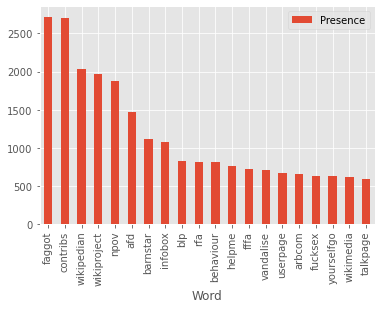

In [143]:
freq_count_df.groupby('Word').sum().sort_values('Presence',ascending=False).nlargest(20,'Presence').plot(kind='bar')

In [33]:
def vectorize(df,count=False,tfidf=False,max_f = 5000):
    if count == True:
        vect = CountVectorizer(max_features=max_f)
    elif tfidf == True:
        vect = TfidfVectorizer(max_features=max_f)
    df_nonempty = df[df['tokens'].str.len()!=0]
    X = df_nonempty[['clean_text','tokens']]
    y = df_nonempty[labels]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    train_vect = vect.fit_transform(X_train['clean_text'])
    test_vect = vect.transform(X_test['clean_text'])
    return train_vect, test_vect, y_train, y_test

X_train, X_test, y_train, y_test = vectorize(df_test,count=True,tfidf=False,max_f=None)